In [1]:
import re
import requests
import locale
from pathlib import Path
from datetime import datetime

import keras
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup

In [2]:
# Environment parameters
plt.rcParams['figure.figsize'] = [20, 10]

# Dataset parameters
DATASET_FOLDER = Path('../dataset/2023.09.10')
CPI_FILENAME = 'RUS_rosstat_cpi.xlsx'
BUDGET_SPENDING_FILENAME = 'RUS_budget_spending.xlsx'
LOANS_FILENAME = 'RUS_loans.xlsx'
AVERAGE_INCOME_FILENAME = 'RUS_rosstat_wages.xlsx'

In [3]:
# Model parameters
INPUT_MONTHS = 12
OUTPUT_MONTHS = 12

# 1 Data Load  
In this section I will load the following datasets:
1. **The Consumer Price Index (CPI).** 
2. **Expenditure Budget.** 
3. **Loans.**
4. **Exchange rates**
5. **Key Rate, RUONIA**
6. **Average wages**
7. **Seasonality (auto generated data)**
  
In the future, when I start developing the final version of the model, the input data will be significantly expanded. Also, if the model provides accurate data for the CPI, I will use additional labels: different categories of the CPI (e.g., services, food).
  
## 1.1 The Consumer Price Index  
Two government organisations in Russia publish the CPI: Central Bank for Russia and Rosstat (Russia Statistics). Both departments release data on a monthly basis. The Central Bank of Russia provides SOAP API interfaces to retrieve the CPI data. However, they provide data only from Sep 2013. Rosstat, in turn, publishes data starting from Jan 1991. However, it's only in the Excel file from the website.  
  
Data source:  
1. Website: https://rosstat.gov.ru/statistics/price.  
2. Цены, инфляция (prices, inflation in English).  
3. Индексы потребительских цен (In English: Consumer price indices).  
4. Индексы потребительских цен на товары и услуги по Российской Федерации, месяцы (с 1991 г.) (In English:  Consumer price indices for goods and services in the Russian Federation, months (since 1991)).  
5. Download XLSX file.  
  
I save the Excel file in the DATASET_FOLDER folder. The saved file will be loaded and converted to DataFrame by the Python pandas framework.   
  
The CPI will be used as samples (input data) and as labels (output data). The labels will be shifted forward in a few months. This way, the model will use previous inflation and be able to predict future inflation.

In [4]:
# Load an excel file
path = DATASET_FOLDER / CPI_FILENAME
df = pd.read_excel(path, sheet_name=1, header=3)

# Drop unused rows
df.drop([0, 13, 14, 15, 16, 17], axis=0, inplace=True)

# Unpivot the DataFrame
df = df.melt(id_vars=['Unnamed: 0'])

# Rename columns
mapping = {'Unnamed: 0':'month', 'variable':'year', 'value':'CPI'}
df.rename(columns=mapping, inplace=True)

# Replace month names in Russian by digits in a month column
mapping = {'январь':1, 'февраль':2, 'март':3, 'апрель':4, 'май':5, 'июнь':6, 
           'июль':7, 'август':8, 'сентябрь':9, 'октябрь':10, 'ноябрь':11, 
           'декабрь':12}
df['month'].replace(mapping, inplace=True)

# Add a new date column based on a year and a month
df['Date'] = pd.to_datetime({'year':df['year'], 'month':df['month'], 'day':1})

# Drop the year and month columns
df.drop(['month', 'year'], axis=1, inplace=True)

# Drop all rows with NaN values
df.dropna(subset=['CPI'], axis=0, inplace=True)

# Change data types
dtypes = {'Date':'datetime64[ns]', 'CPI':'float64'}
df = df.astype(dtypes)

# Set the date column as an index
df.set_index('Date', inplace=True)

# Resample date from the first day of a month to the last one
df = df.resample('M').last()

# Calculate compound interest with roundings by two decimals.
# The same methodology uses Rosstat when calculates the CPI
def prod(x):
    y = x[0]
    for i in range(len(x) - 1):
        y = y * x[i + 1] / 100
        y = round(y, 2)
    return y - 100

df = df.rolling(window=12, min_periods=12).apply(prod, raw=True)

# Drop all rows with NaN values
df.dropna(subset=['CPI'], axis=0, inplace=True)

# copy the loaded DataFrame to df_cpi to simplify further usage
df_cpi = df.copy()

## 1.2 Expenditure Budget
The Russian Ministry of Finance publishes budget expenditures. The data has been published every month since January 2011. These are the essential data that, along with credit (loans), determine spending in the economy and, as a result, are pro-inflationary. The Ministry of Finance publishes spending in various categories: utilities, environmental protection, education, medicine, etc. All of them are important for determining inflation. However, in order to simplify the prototype, I will use the total budget costs. The data is published only in Excel format.
  
Data source:  
1. Web: https://minfin.gov.ru/ru/statistics/fedbud/execute?id_57=80042-informatsiya_ob_ispolnenii_federalnogo_byudzheta  
2. СКАЧАТЬ (XLSX, 0.18 MB) (In English: : Download (XLSX, 0.18 MB))  
  
I save the Excel file in the DATASET_FOLDER folder. The saved file will be loaded and converted to DataFrame by the Python pandas framework.  
The Expenditure Budget will be used only as samples (input data).

In [5]:
# Load the excel file
path = DATASET_FOLDER / BUDGET_SPENDING_FILENAME
df = pd.read_excel(path, sheet_name=0, header=2, skipfooter=2)

# Drop the unused rows and columns
df.drop([13, 29, 32], axis=0, inplace=True)
df.drop(['Unnamed: 0'], axis=1, inplace=True)

# Unpivot the DataFrame
df = df.melt(id_vars=['РАЗДЕЛ I'])

# Rename the columns
mapping = {'РАЗДЕЛ I':'metric', 'variable':'Date'}
df.rename(columns=mapping, inplace=True)

# Replace the Russian month names with numbers
mapping = {'янв.23 ***':'2023.01.01', 'фев.23 ***':'2023.02.01' ,
           'мар.23 **':'2023.03.01', 'апр.23 **':'2023.04.01',
           'июл.23 **':'2023.07.01'}
df['Date'].replace(mapping, inplace=True)

# Replace the Russian category names with English
mapping = {'Расходы, всего':'Gov spending all'}
df['metric'].replace(mapping, inplace=True)

# Convert the date column to the datetime64[ns] format
df['Date'] = pd.to_datetime(df['Date'])

# Drop all rows with NaN values
df.dropna(subset=['value'], axis=0, inplace=True)

# Set the date column as an index
df.set_index('Date', inplace=True)

# Filter out all metrics but the goverment spending values
filter_condition = (df['metric'] == 'Gov spending all')
df = df.loc[filter_condition, :]

# Pivot the table: move metrics to columns
df = df.pivot_table(values='value', index='Date', columns=['metric'])


# We need clean government spending data. However, the data in the Excel table
# are summarized throughout the year. the script below deletes the sum of 
# spendings for the previous months during the year.
# For instance, Apr = Apr cumulative - (Mar + Feb + Jan)
year_min = min(df.index.year)
year_max = max(df.index.year)
last_month = max(df.loc[df.index.year == year_max].index.month)

# Itterate over all years in the dataset
for year in range(year_min, year_max + 1, 1):
    sum_year = 0

    # Iterate over all months in dataset
    for month in range(2, 13, 1):
        # Sum of spending in the year
        sum_year += df.loc[np.bitwise_and(df.index.year == year, 
                                          df.index.month == month - 1), 
                                          'Gov spending all'][0]

        # Subtract previous spendings during a year from a month cumulative
        # spendings
        df.loc[np.bitwise_and(df.index.year == year,
                              df.index.month == month),
                              'Gov spending all'] = \
            df.loc[np.bitwise_and(df.index.year == year,
                                df.index.month == month),
                                'Gov spending all'][0] \
            - sum_year
        
        # Break when last month in the dataset
        if year == year_max and month == last_month: break

# Resample date from the first day of a month to the last one
df = df.resample('M').last()

# Copy the loaded DataFrame to df_cpi to simplify further usage
df_exp_budget = df.copy()

## 1.3 Credits / Loans  
Loan data has been published in Excel format by the Central Bank of Russia monthly since February 2008. The data contains many categories, but I am primarily interested in loans for individuals and legal entities. According to Modern Monetary Theory (MMT), the government is unlimited in its spending. However, individuals and businesses have to increase credit to increase consumption. Thus, I will use the following data for loans: loans for individuals, individual entrepreneurs, and companies.

Data Source:  
1. Web: https://www.cbr.ru/statistics/bank_sector/review/.  
2. Динамические ряды показателей отдельных таблиц сборника «Статистические показатели банковского сектора Российской Федерации» (In English: Dynamic series of indicators of individual tables of the collection "Statistical indicators of the banking sector of the Russian Federation").
3. Download the XLSX file.  
  
I save the Excel file in the DATASET_FOLDER folder. The saved file will be loaded and converted to DataFrame by the Python pandas framework.  
The loan data will be used only as samples (input data).  

In [6]:
# Load the excel file
path = DATASET_FOLDER / LOANS_FILENAME
df = pd.read_excel(path, sheet_name=0, header=1, skipfooter=6)

# Drop the unused rows and columns
df.drop(['Unnamed: 0'], axis=1, inplace=True)

# Unpivot the DataFrame
df = df.melt(id_vars=['Активы - в рублях и иностранной валюте'])

# Rename the columns
mapping = {'Активы - в рублях и иностранной валюте':'metric',
           'variable':'date'}
df.rename(columns=mapping, inplace=True)

# Replace the Russian category names with English
mapping = {'Корпоративные кредиты':'Corporate loans', 
           'Индивидуальные предприниматели':'Individual entrepreneur loans', 
           'Физические лица':'Individual loans'}
df['metric'].replace(mapping, inplace=True)

# Drop all rows with NaN values
df.dropna(subset=['value'], axis=0, inplace=True)

# Set the date column as an index
df.set_index('date', inplace=True)


# Filter out all data byt the loan values that we need
filter_condition = (df['metric'] == 'Corporate loans') | \
                   (df['metric'] == 'Individual entrepreneur loans') | \
                   (df['metric'] == 'Individual loans')
df = df.loc[filter_condition, :]

# Pivot the table: move metrics to columns
df = df.pivot_table(values='value', index='date', columns=['metric'])

# Resample date from the first day of a month to the last one
df = df.resample('M').last()

# Rename index column
df.index.rename('Date', inplace=True)

# Change data types
dtypes = {'Corporate loans':'float64', 'Individual entrepreneur loans':'float64', 'Individual loans':'float64'}
df = df.astype(dtypes)

# Copy the loaded DataFrame to df_cpi to simplify further usage
df_loans = df.copy()

## 1.4 Exchange rates USDRUB, EURRUB, CNYRUB
Given that Russia is highly dependent on imports from Europe, the USA, and China, exchange rates should have a high impact on inflation. I will download the following exchange pairs:  
- USDRUB (the US Dollar to Ruble)
- EURRUB (Euro to Ruble)
- CNYRUB (China Yuan to Ruble)


Data source:  
1. Central Bank Russia, The API documentation: http://www.cbr.ru/development/sxml/ 
2. The XML response XSD schema http://www.cbr.ru/StaticHtml/File/92172/ValCurs.xsd
3. Currencies IDs, Web: http://www.cbr.ru/scripts/XML_val.asp?d=0  
    USDRUB, US Dollar - "R01235"  
    EURRUB, Euro - "R01239"  
    CNYRUB, China Yuan - "R01375"  
4. GET API Request Example: http://www.cbr.ru/scripts/XML_dynamic.asp?date_req1=02/03/2001&date_req2=14/03/2001&VAL_NM_RQ=R01235

In [7]:
def get_exchange_rate(*,
                      start_date: str = '01/01/2010',
                      end_date: str = datetime.today().strftime('%d/%m/%Y'),
                      currency_pairs: list):
    """The exchange rates loader from Central Bank Russia.
    The REST API description: http://www.cbr.ru/development/sxml/ (in Russian)
    The schema description:
    http://www.cbr.ru/StaticHtml/File/92172/ValCurs_dynamics.xsd

    Parameters
    ----------
    start_date : str
        The beginning of the range for which the exchange rates will be loaded.
        The format is: DD/MM/YYYY
    
    end_date: str
        The end of the range for which the exchange rates will be loaded.
        The format is: DD/MM/YYYY

    currency_pairs: list
        The list of currency pairs to be loaded. Currencies myst be in the
        ISO 4217 Alpha 3 code format.
        Supported currency pairs: 'USDRUB', 'EURRUB', 'CNYRUB'.
        Example: ['USDRUB', 'EURRUB', 'CNYRUB']

    Returns
    ----------
    pandas.DataFrame
        A pandas DataFrame with exchange rates for the requested currencies on
        success, or None.
    """
    # =========================================================================
    # ASSERTIONS
    # Type Errors
    if not isinstance(start_date, str):
        raise TypeError(f'start_date must be a string, not {type(start_date)}')
    
    if not isinstance(end_date, str):
        raise TypeError(f'end_date must be a string, not {type(end_date)}')    

    if not isinstance(currency_pairs, list):
        raise TypeError(f'currency_pairs must be a list, not '
                        f'{type(currency_pairs)}')
    
    if not all([isinstance(x, str)] for x in currency_pairs):
        raise TypeError('All exchange_rates must be strings')
    
    # Value Errors
    date_regex = re.compile(r'^[0-3][0-9]\/[0-1][0-9]\/[0-2][0-9]{3}$')
    iso_alpha3_regex = re.compile(r'^[A-Z]{6}$')

    if date_regex.match(start_date) is None:
        raise ValueError('start_date must be in the "DD/MM/YYYY" format')

    if date_regex.match(end_date) is None:
        raise ValueError('end_date must be in the "DD/MM/YYYY" format')
    
    if any([iso_alpha3_regex.match(x) is None for x in currency_pairs]):
        raise ValueError('All currencies must be in the ISO 4217 Alpha 3 '
                         'code format')
    
    if any([x not in ['USDRUB', 'EURRUB', 'CNYRUB']  for x in currency_pairs]):
        raise ValueError('Only USD, EUR and CNY currencies are supported')
    
    # ==========================================================================
    # REQUEST PARAMETERS

    CURENCY_MAPPING = {'USDRUB':'R01235', 'EURRUB':'R01239',
                       'CNYRUB':'R01375'}

    server_url = 'https://www.cbr.ru/'
    endpoint = 'scripts/XML_dynamic.asp'
    start_date = 'date_req1='+start_date+'&' if start_date is not None else ''
    end_date = 'date_req2='+end_date+'&' if end_date is not None else ''
    cp_codes = ['VAL_NM_RQ='+CURENCY_MAPPING[cp] for cp in currency_pairs]
    
    # ==========================================================================
    # REQUEST SERVER
    # Request example:
    # http://www.cbr.ru/scripts/XML_dynamic.asp?date_req1=02/03/2001&date_req2=14/03/2001&VAL_NM_RQ=R01235

    # set locale to Russian to process floats correctly
    locale.setlocale(locale.LC_ALL, 'ru_RU')

    # a dict to save results
    records_all = {'currency_pair':[],
                   'Date':[],
                   'value':[]}
    
    for i, cp in enumerate(currency_pairs):
        
        # Request the server
        request_url = server_url + endpoint + '?' + start_date + end_date \
                      + cp_codes[i]
        headers = {'Host':'www.cbr.ru',
                'Content-Type':'application/soap+xml; charset=utf-8'}
        response = requests.post(request_url, headers=headers)

        # print status
        print('Request URL:', request_url)
        print('Response URL:', response.url)
        print('Status:', response.status_code)
        
        # assertion if a response is not 200
        if response.status_code >= 300:
            print('Error:', response.text)
            return None
        
        # =====================================================================
        # PROCESS XML RESPONSE

        # Parse the XML content
        xml = BeautifulSoup(response.content, features="xml")

        # Find all records
        xml_elements = xml.find_all('Record')

        # Retrieve data from records
        for el in xml_elements:
            records_all['currency_pair'].append(cp)
            records_all['Date'].append(el['Date'])
            nominal = locale.atof(el.find('Nominal').contents[0])
            value = locale.atof(el.find('Value').contents[0])
            records_all['value'].append(value/nominal)

    # save records in DataFrame, parse dates
    df = pd.DataFrame(data=records_all)
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
    
    # set date as index and sort
    df.set_index('Date', inplace=True)
    
    return df
    

In [8]:
# Request the Central Bank Russia API and Load exchange rates data
df_exchange_rates = get_exchange_rate(start_date='01/01/1990',
                                      currency_pairs=['USDRUB', 'EURRUB',
                                                      'CNYRUB'])

# Pivot table. Move metrics to columns
df_exchange_rates = df_exchange_rates.pivot_table(values='value', index='Date',
                                                  columns=['currency_pair'])

# Calculate an average monthly exchange rate
df_exchange_rates = df_exchange_rates.resample('M').mean()

# Drop rows with NaN values
df_exchange_rates.dropna(subset=['USDRUB', 'EURRUB', 'CNYRUB'],
                         axis=0,
                         inplace=True)

Request URL: https://www.cbr.ru/scripts/XML_dynamic.asp?date_req1=01/01/1990&date_req2=10/09/2023&VAL_NM_RQ=R01235
Response URL: https://www.cbr.ru/scripts/XML_dynamic.asp?date_req1=01/01/1990&date_req2=10/09/2023&VAL_NM_RQ=R01235
Status: 200
Request URL: https://www.cbr.ru/scripts/XML_dynamic.asp?date_req1=01/01/1990&date_req2=10/09/2023&VAL_NM_RQ=R01239
Response URL: https://www.cbr.ru/scripts/XML_dynamic.asp?date_req1=01/01/1990&date_req2=10/09/2023&VAL_NM_RQ=R01239
Status: 200
Request URL: https://www.cbr.ru/scripts/XML_dynamic.asp?date_req1=01/01/1990&date_req2=10/09/2023&VAL_NM_RQ=R01375
Response URL: https://www.cbr.ru/scripts/XML_dynamic.asp?date_req1=01/01/1990&date_req2=10/09/2023&VAL_NM_RQ=R01375
Status: 200


## 1.5 Key Rate, RUONIA, Interbank credit rate
The main method of controlling inflation in monetary policy is through a decrease or increase in the **Key Ratio**. By lowering the key rate, the central bank makes borrowing more accessible, and savings through deposits or buying bonds less attractive. Despite the fact that this approach has a large number of critics, especially from macroeconomists of the left views, this practice is widely practiced in the modern world.

**RUONIA** (Ruble Overnight Index Average) is a weighted average rate of unsecured overnight ruble lending transactions on the Russian money market.  RUONIA is used as a reference rate for financial instruments, including derivatives, and provides a representation of the cost of unsecured borrowing in the Russian ruble on an overnight basis. The rate is typically calculated and published by the Central Bank of Russia based on the actual transaction data it collects. Interest rate benchmarks like RUONIA play a critical role in financial markets, as they are used as reference rates for a wide range of financial products, such as loans, deposits, and derivatives.

The **Interbank credit market rate** refers to the interest rate at which banks lend to and borrow from one another in the interbank market. This rate is often for short-term loans, typically overnight, although longer-term interbank loans also exist. Central banks use the interbank market to implement monetary policy. By targeting the interbank rate, central banks can influence broader interest rates in the economy, affecting borrowing costs for households and businesses.

Data sources:
1. Key Ratio, Web chart: https://www.cbr.ru/eng/hd_base/KeyRate/
2. RUONIA, web chart: https://www.cbr.ru/eng/hd_base/ruonia/dynamics/
3. Interbank Money Market, web chart: https://www.cbr.ru/eng/hd_base/mkr/mkr_base/
4. SOAP API. Methods description: https://www.cbr.ru/development/DWS/ (only in Russian)
5. SOAP API. Methods description: https://www.cbr.ru/DailyInfoWebServ/DailyInfo.asmx (only in Russian)

I took the data loader implementation from my CM3005 Data Science, Midterm project.

In [9]:
def get_data_API_CBRF(*,
                      dataset : str = 'key_rate',
                      date_from : str = '2010-01-01T00:00:00.0000000+00:00',
                      date_to : str = datetime.today().isoformat()):
    """SOAP API data loader Central bank of the Russian Federation
    Methods description: https://www.cbr.ru/development/DWS/ (only in Russian)
    Methods description: https://www.cbr.ru/DailyInfoWebServ/DailyInfo.asmx (only in Russian)

    Parameters
    ----------
    dataset : str
        Dataset to be requested. Supported datasets:
        'KeyRate' - Key rate dynamics
        'Ruonia' - RUONIA (Ruble Overnight Index Average) rate
        'MKR' - Interbank credit market rates

    date_from : str
        A start date of the data loading window. The ISO 8601 format must be used.

    date_to : str
        An end date of the data loading window. The ISO 8601 format must be used.

    Returns
    ----------
    A pandas DataFrame with dataset on Success, or None.
    """
    # =========================================================================
    # ASSERTIONS
    # Type Errors
    if not isinstance(dataset, str):
        raise TypeError(f'metric must be an str, not {type(dataset)}')

    if not isinstance(date_from, str):
        raise TypeError(f'date_from must be an str, not {type(date_from)}')

    if not isinstance(date_to, str):
        raise TypeError(f'date_to must be an str, not {type(date_to)}')

    # Value Errors
    if dataset not in ['KeyRate', 'Ruonia', 'MKR']:
        raise ValueError('Only KeyRate, RUONIA, MKR datasets are supported')

    # ISO 8601 regex
    # the solution taken from https://stackoverflow.com/questions/41129921/validate-an-iso-8601-datetime-string-in-python
    iso_regex = r'^(-?(?:[1-9][0-9]*)?[0-9]{4})-(1[0-2]|0[1-9])-(3[01]|0[1-9]|[12][0-9])T(2[0-3]|[01][0-9]):' \
    '([0-5][0-9]):([0-5][0-9])(\.[0-9]+)?(Z|[+-](?:2[0-3]|[01][0-9]):[0-5][0-9])?$'
    match_iso8601 = re.compile(iso_regex)
    if not match_iso8601.match(date_from):
        raise ValueError('date_from must be in the ISO 8601 format')

    if not match_iso8601.match(date_to):
        raise ValueError('date_to must be in the ISO 8601 format')

    # =========================================================================
    # Constants and variables
    SERVER_URL = 'https://www.cbr.ru/'
    ENDPOINT = '/DailyInfoWebServ/DailyInfo.asmx'
    request_url = SERVER_URL + ENDPOINT

    HEADERS = {'Host':'www.cbr.ru', 'Content-Type':'application/soap+xml; charset=utf-8'}


    body = f'''<?xml version="1.0" encoding="utf-8"?>
    <soap12:Envelope xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xmlns:xsd="http://www.w3.org/2001/XMLSchema" xmlns:soap12="http://www.w3.org/2003/05/soap-envelope">
        <soap12:Body>
            <{dataset} xmlns="http://web.cbr.ru/">
                <fromDate>{date_from}</fromDate>
                <ToDate>{date_to}</ToDate>
            </{dataset}>
        </soap12:Body>
    </soap12:Envelope>'''

    # =========================================================================
    # Request the server
    response = requests.post(request_url, data=body, headers=HEADERS)

    # print status
    print('Request URL:', response.url)
    print('Status:', response.status_code)

    if response.status_code >= 300:
        print('Error:', response.text)
        return None

    # =========================================================================
    # Parse the XML response string
    xml = BeautifulSoup(response.content, features="xml")

    if dataset == 'MKR':
        xml_elements = xml.find('mkr_base').contents
    else:
        xml_elements = xml.find(dataset).contents

    # =========================================================================
    # Save the XML data in an pandas DataFrame
    data = {}
    df = pd.DataFrame()

    # Iterate all data elements
    for xml_el in xml_elements:
        # Iterate each element and add data to the data dictionary
        for e1 in xml_el.children:
            # Save all data to dict
            data[e1.name] = e1.contents[0]

        # Append data to DataFrame
        df = pd.concat([df, pd.DataFrame([data])], ignore_index=True)

    # =========================================================================
    # PREPROCESSING
    # Rename column names
    MAPPING = {'DT':'Date', 'D0':'Date', 'CDate':'Date', 'Rate':'Key Ratio', 'ruo':'RUONIA', 'vol':'RUONIA volume'}
    df.rename(MAPPING, axis=1, inplace=True)

    # Change data types
    if dataset == 'KeyRate':
        dtypes = {'Key Ratio':'float64', }
    elif dataset == 'Ruonia':
        dtypes = {'RUONIA':'float64', 'RUONIA volume':'float64'}
    elif dataset == 'MKR':
        dtypes = {'p1':'int64', 'd1':'float64'}

    df = df.astype(dtypes)
    df['Date'] = pd.to_datetime(df['Date'], utc=True).dt.date

    # Set the date column as an index
    df.set_index('Date', inplace=True)
    df.index = pd.to_datetime(df.index)

    return df

In [10]:
# Load the Key rate
df_key_rate = get_data_API_CBRF(dataset='KeyRate')

# Resample daily data to monthly
df_key_rate = df_key_rate['Key Ratio'].resample('M').mean()

Request URL: https://www.cbr.ru//DailyInfoWebServ/DailyInfo.asmx
Status: 200


In [11]:
# Load RUONIA rate
df_ruonia = get_data_API_CBRF(dataset='Ruonia')

# Drop columns
df_ruonia.drop(columns=['DateUpdate'], inplace=True)

# Resample daily data to monthly
df_ruonia = df_ruonia[['RUONIA', 'RUONIA volume']].resample('M').mean()

Request URL: https://www.cbr.ru//DailyInfoWebServ/DailyInfo.asmx
Status: 200


In [12]:
# Load Indicators of the rates of the Interbank credit market rates
df_mkr = get_data_API_CBRF(dataset='MKR')

# Extract the weighted average actual rate on loans in rubles provided by Moscow bank (p1 = 3)
df_mkr_p1_3 = df_mkr.loc[df_mkr.loc[:, 'p1'] == 3, 'd1']
df_mkr_p1_3.rename('Moscow InterBank Rate', inplace=True)

# Extract Turnover of operations on loans in rubles provided by Moscow banks (p1 = 5)
df_mkr_p1_5 = df_mkr.loc[df_mkr.loc[:, 'p1'] == 5, 'd1']
df_mkr_p1_5.rename('Moscow InterBank Turnover', inplace=True)

# Merge and delete tempary tables
df_mkr = pd.concat([df_mkr_p1_3, df_mkr_p1_5], axis=1, join='outer')
del df_mkr_p1_3, df_mkr_p1_5

# Resample daily data to monthly
df_mkr = df_mkr[['Moscow InterBank Rate', 'Moscow InterBank Turnover']].resample('M').mean()

Request URL: https://www.cbr.ru//DailyInfoWebServ/DailyInfo.asmx
Status: 200


In [13]:
# Merge all columns
df_kr_ruonia_mkr = pd.concat([df_key_rate, df_ruonia, df_mkr], axis=1)

## 1.6 Average wages
Average wages refers to the mean monetary earnings of a group of individuals, households, or entities within a specified region or country, usually calculated over a specific time frame, such as a month or year. It provides an indication of the economic well-being and standard of living of the population of that area.

Inflation represents the general rise in the price level of goods and services in an economy over a period of time. When inflation is high and wages don't increase at the same pace, the real purchasing power of wages decreases. This means that an individual's salary will buy less than it did previously. For workers to maintain their standard of living, wages must increase at least at the same rate as inflation.

Data Source:
1. Website: https://rosstat.gov.ru/labor_market_employment_salaries
2. Рынок труда, занятость и заработная плата
3. Среднемесячная номинальная начисленная заработная плата работников организаций (In English: Average monthly nominal accrued wages of employees of organizations).
4. Среднемесячная номинальная начисленная заработная плата работников в целом по экономике Российской Федерации в 1991-2023 гг. (In English: Average monthly nominal accrued wages of employees in the whole economy of the Russian Federation in 1991-2023).
5. Download an XLSX file.

In [14]:
# Load the excel file
path = DATASET_FOLDER / AVERAGE_INCOME_FILENAME
df = pd.read_excel(path, sheet_name=0, header=4, skipfooter=4)

# Drop the unused rows and columns
df.drop(['В среднем за год ', 'В среднем за кварталы', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5'], axis=1, inplace=True)
df.drop([0, 1], axis=0, inplace=True)

# Unpivot the DataFrame
df = df.melt(id_vars=['Unnamed: 0'])

# Rename columns
MAPPING = {'Unnamed: 0':'Year', 'variable':'Month', 'value':'Wages'}
df.rename(columns=MAPPING, inplace=True)

# Replace the month names in Russian by digits in a month column
mapping = {'Январь':1, 'Февраль':2, 'Март':3, 'Апрель':4, 'Май':5, 'Июнь':6,
           'Июль':7, 'Август':8, 'Сентябрь':9, 'Октябрь':10, 'Ноябрь':11,
           'Декабрь':12}
df['Month'].replace(mapping, inplace=True)

# Delete references in Dates and Values
df.replace(to_replace='\([1-2]\)', value='', inplace=True, regex=True)

# # Add a new date column based on a year and a month
df['Date'] = pd.to_datetime({'year':df['Year'], 'month':df['Month'], 'day':1})
#
# # Drop the year and month columns
df.drop(['Month', 'Year'], axis=1, inplace=True)

# Drop all rows with NaN values
df.dropna(subset=['Wages'], axis=0, inplace=True)

# Change data types
dtypes = {'Date':'datetime64[ns]', 'Wages':'float64'}
df = df.astype(dtypes)

# Set the date column as an index
df.set_index('Date', inplace=True)

# Resample date from the first day of a month to the last one
df = df.resample('M').last()

df_wages = df.copy()

## 1.7 Seasonality (auto generated)
Incorporating sinusoidal (sine or cosine) terms in time series models can be beneficial for capturing periodic or cyclical patterns in the data. These patterns are commonly found in many real-world time series data, such as temperature data, sales data, and financial data. 

I will prepare the sine data to follow a yearly cycle, which should make it easier to adjust the model for seasonal data.

In [15]:
START_DATE = '1990-01-01'
END_DATE = '2023-12-31'

# Range between dates
range_ = pd.date_range(start=START_DATE, end=END_DATE, freq='M')

# The sin function along data range
sin_ = np.resize(np.sin(np.linspace(-np.pi, np.pi, 12)), len(range_))

# Create a pandas DataFrame
df_sin = pd.DataFrame(sin_, columns=['Sin'])

# Replace index
df_sin.index = range_

In [16]:
df_sin

,Sin
1990-01-31,-1.224647e-16
1990-02-28,-5.406408e-01
1990-03-31,-9.096320e-01
1990-04-30,-9.898214e-01
1990-05-31,-7.557496e-01
...,...
2023-08-31,7.557496e-01
2023-09-30,9.898214e-01
2023-10-31,9.096320e-01
2023-11-30,5.406408e-01


Feature to be extracted / developed:  
1. All metrics must be not in nominal values but reduced to one year, taking into account inflation
2. For each metric, calculate the delta to the previous period
3. Government debt to GDP ratio
4. Extrapolate monthly data for each day

# 2 Data Analytics and Visualisation
Before moving on to preparing the model, it makes sense to examine the loaded data. The data may contain missing data, outliers, and other anomalies. Also, data animation will help to understand the general trend and show the presence or absence of seasonal anomalies.

In this section, I will provide descriptive statistics, which include:
- Measure of central tendency;
- Measure of variability;
- Measure of frequency.

There are three main measures of the central tendency:
- Mean (Average);
- Median;
- Mode.
  
Also, there are three measures of spread (variability):
- Value range;
- standard deviation;
- variance.
  
For a measure of frequency, I measure:
- Measurement frequency;
- Data date range;
- Data count.

## 2.1 The Consumer Price Index
First of all, we need to check that there are no NaN values:

In [17]:
df_cpi.isna().sum()

CPI    0
dtype: int64

In [18]:
df_cpi.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CPI,381.0,104.698609,305.772116,2.2,6.8,11.6,19.39,2508.8


It is worth noting the following points:
1. The difference between the mean and median values is nine times. A clear indication that our dataset has outliners.
2. The measured standard deviation exceeds the mean by 2.9 times. This is a considerable difference, indicating that the current CPI is unreliable.
3. The maximum CPI (2508.8%) is much higher than the mean value (105.77%).
4. We have data for the last 30 years. However, since the data is measured only once a month, there is not much data.  

The visualisation of the CPI should reveal the situation with outliners.

Data visualisation:

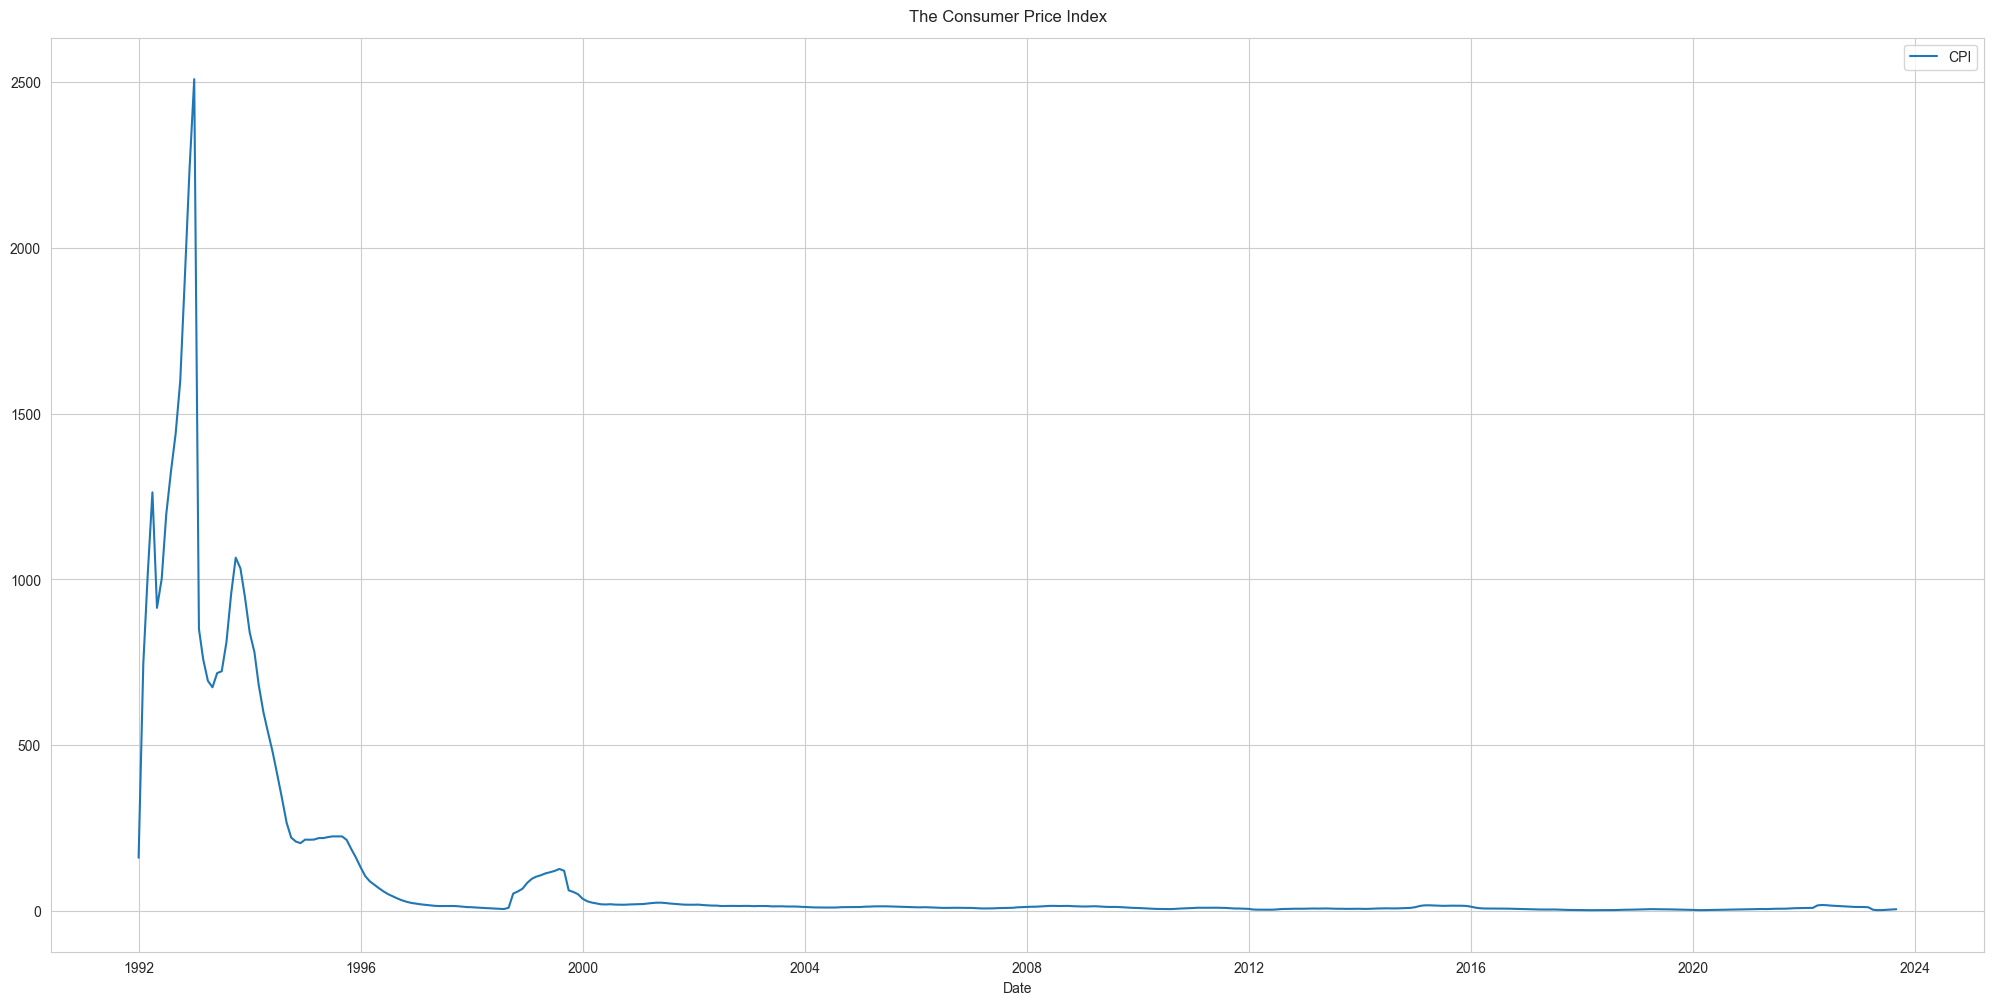

In [19]:
fig, axes = plt.subplots(1, 1, figsize=(20, 10))
fig.suptitle(f'The Consumer Price Index')
fig.tight_layout(pad=1.0)

sns.lineplot(data=df_cpi);

On the chart, we can see clearly the high fluctuation in the CPI from 1992 to 1997 and from 1998 to 2001.  
There are two reasons for that:  
1. The first strong jumps in inflation occurred after the collapse of the Soviet Union. After the destruction of supply chains and the transition to a capitalist economy in 1991, there was a sharp denomination of the currency.
2. The second jump in inflation occurred a year after the debt crisis 1998.
  
It makes sense to remove the data up to 2001 in order to remove the strong jumps in inflation due to shock situations in the economy.

In [20]:
df_cpi_cleaned = df_cpi['2001':].copy()

I will verify the descriptive statistics again:

Major changes:
1. Standard deviation is now 0.55 of the average (it was 2.9).
2. Mean (9.58%), and median (8.90%) are nearly equal now. Before, they were 105.77% and 11.71% consequentially.
3. However, the Data count was significantly reduced from 377 to 268.  

Let's visualise the CPI again:

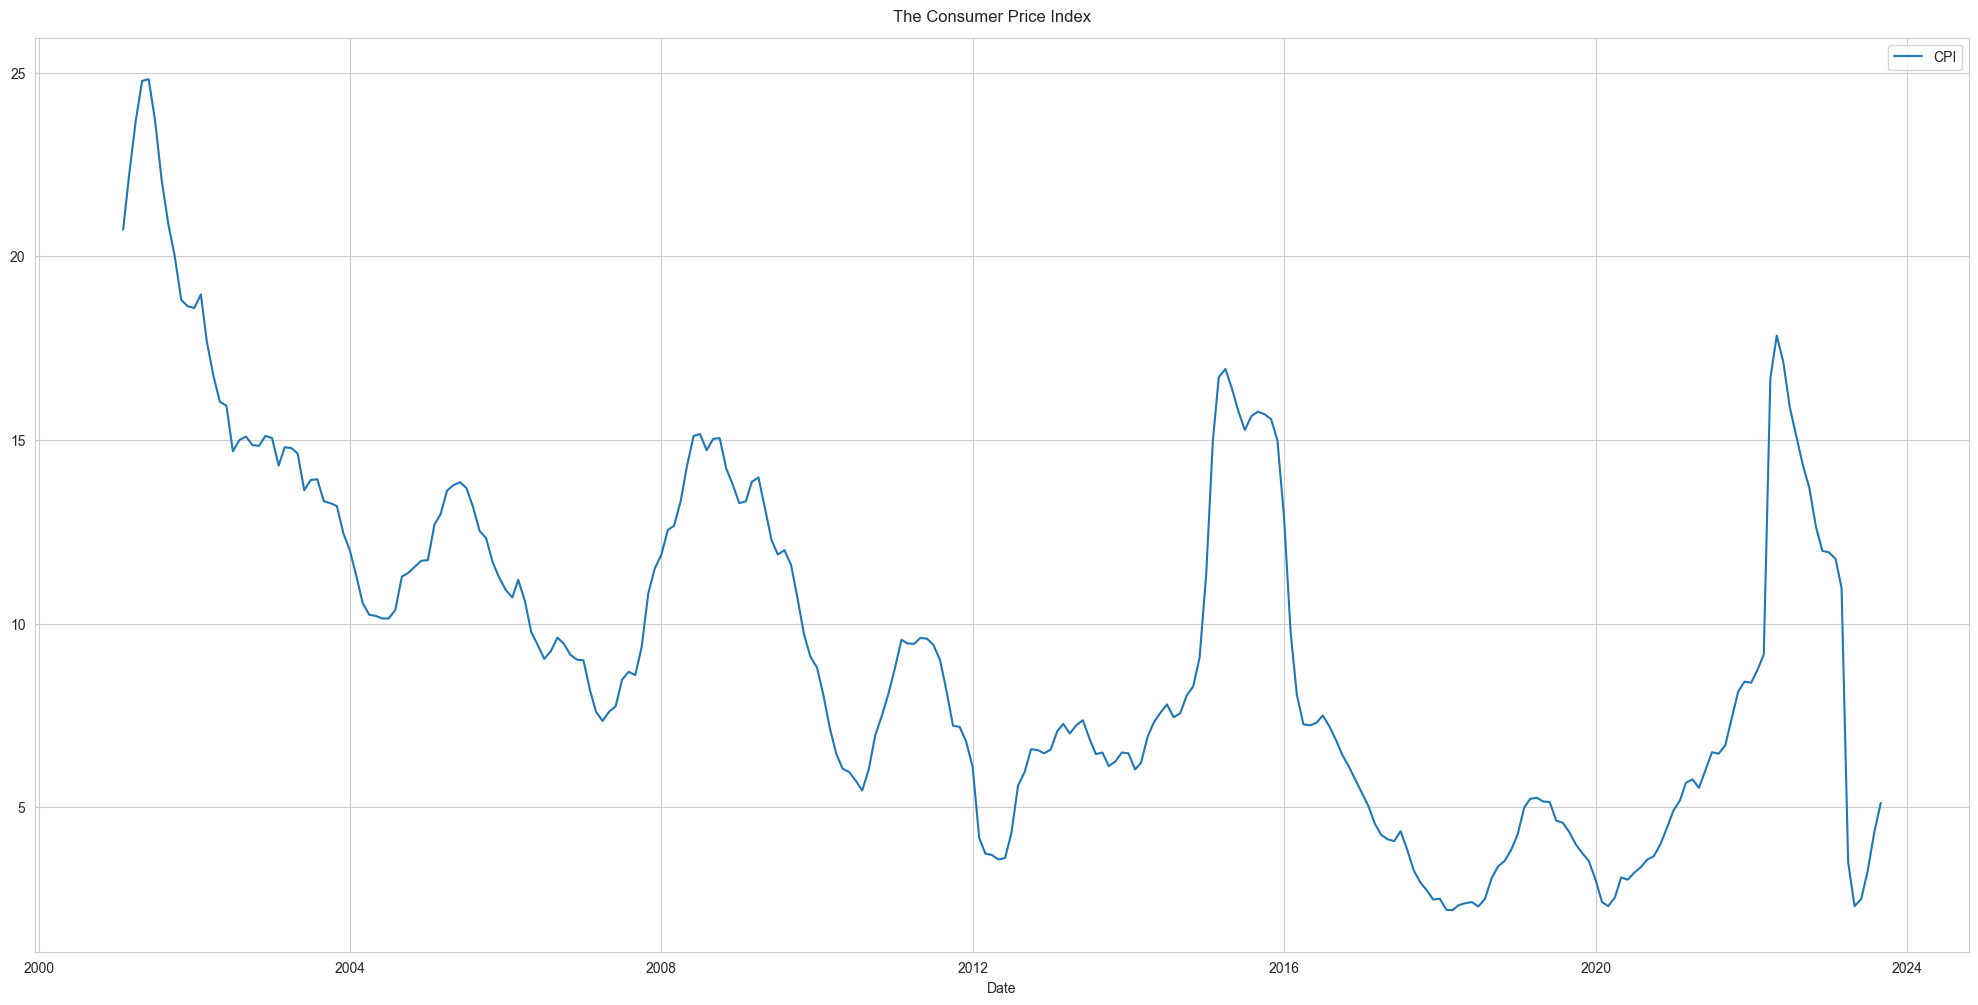

In [21]:
fig, axes = plt.subplots(1, 1, figsize=(20, 10))
fig.suptitle(f'The Consumer Price Index')
fig.tight_layout(pad=1.0)

sns.lineplot(data=df_cpi_cleaned);

The charts still show the peaks of inflation caused by various shocks in the economy:
1. 2007-2008 Global Financial Crisis
2. Annexation of Crimea in 2014
3. Russian - Ukraine War in 2022-present

This segment is a good balance between quality and quantity of data.

## 2.2 Expenditure Budget

In [22]:
df_exp_budget.isna().sum()

metric
Gov spending all    0
dtype: int64

In [23]:
df_exp_budget.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
metric,,,,,,,,
Gov spending all,151.0,1532.607978,812.186791,638.166056,1038.082146,1292.097566,1778.272304,7081.963584


The main observations:
1. There are no missing data and dates in the dataset.
2. The median and the mean do not differ much. This is a good sign that the data does not contain anomalies.
3. The standard deviation is 0.54 from the mean, which also indicates the absence of data anomalies.  
4. Despite the 12 years of data range, we have only 148 data points of Expenditure Budget. It could be the main issue during the training of the machine learning model. 
5. Since government spending does not contain repeated values, there are a large number of modes in the dataset.
  
Data visualisation:

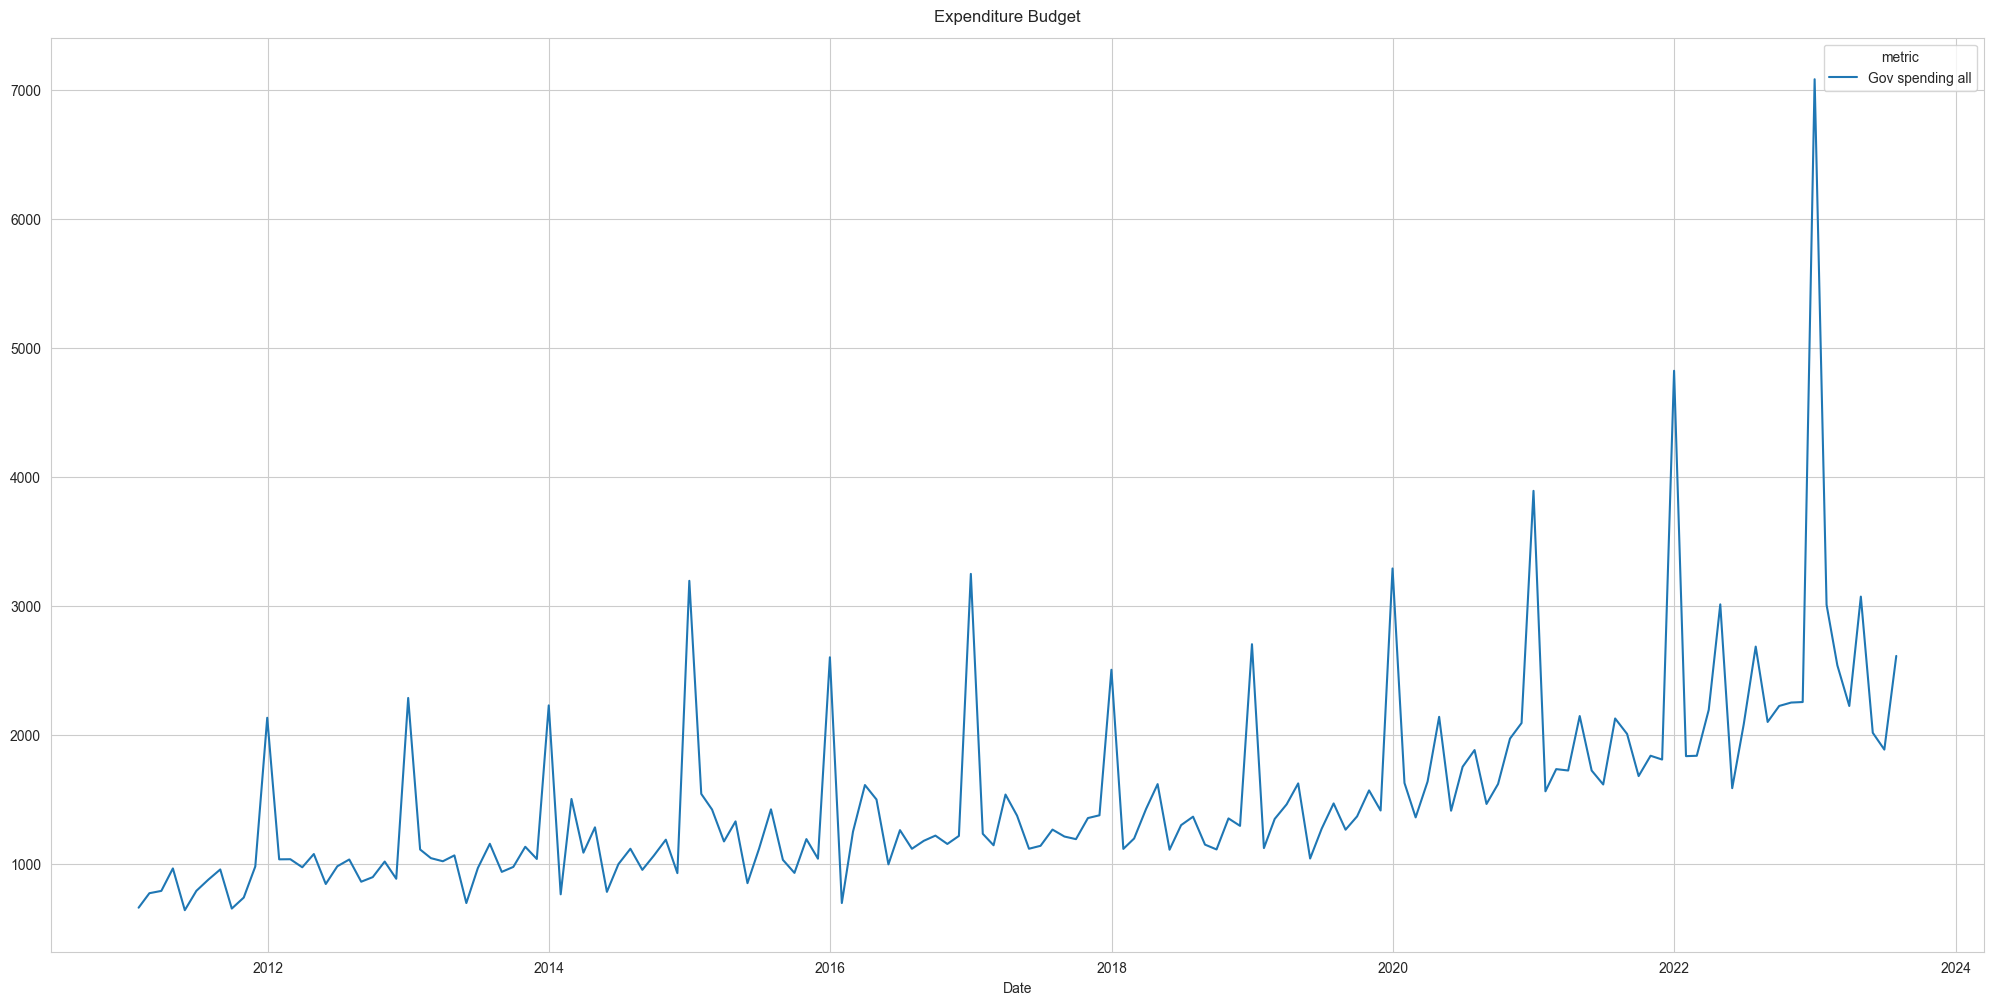

In [24]:
fig, axes = plt.subplots(1, 1, figsize=(20, 10))
fig.suptitle(f'Expenditure Budget')
fig.tight_layout(pad=1.0)

sns.lineplot(data=df_exp_budget);

The chart highlights the seasonality of government spending. The lion's share of expenses falls at the end of the year. This trend has been repeated for the last ten years. Thus, the model should understand well what month it is.  
  
There is also a clear upward trend in public spending in nominal terms.

## 2.3 Credits / Loans  

As usual, we need to check that there are no NaN values:

In [25]:
df_loans.isna().sum()

metric
Corporate loans                  0
Individual entrepreneur loans    0
Individual loans                 0
dtype: int64

In [26]:
df_loans.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
metric,,,,,,,,
Corporate loans,187.0,30699.766038,14172.561164,10029.017913,18094.747696,32763.083709,38655.158233,66625.279342
Individual entrepreneur loans,187.0,514.586947,161.624809,269.067874,419.883486,497.760343,625.420104,1023.294531
Individual loans,187.0,12157.767268,7459.166378,3012.495595,5443.461007,10757.394332,16967.551494,30536.772712


The main observations:
1. There are no missing data and dates in the dataset.
2. The mean and median values are approximately the same for all loan types. This is a good indication that there are no anomalies in the data.  
3. The standard deviation is about 0.5 of the average for all types of loans: 0.4 for Corporate loans, 0.3 for Individual entrepreneur loans, and 0.6 for Individual loans. Perhaps we should take a closer look at individual loans.
4. Despite the 15 years of data range, we have only 181 data points in the Loans dataset. It could be the main issue during the machine learning model training. 
5. Since the loans do not contain repeated values, there are a large number of modes in the dataset.
  
Data visualisation:

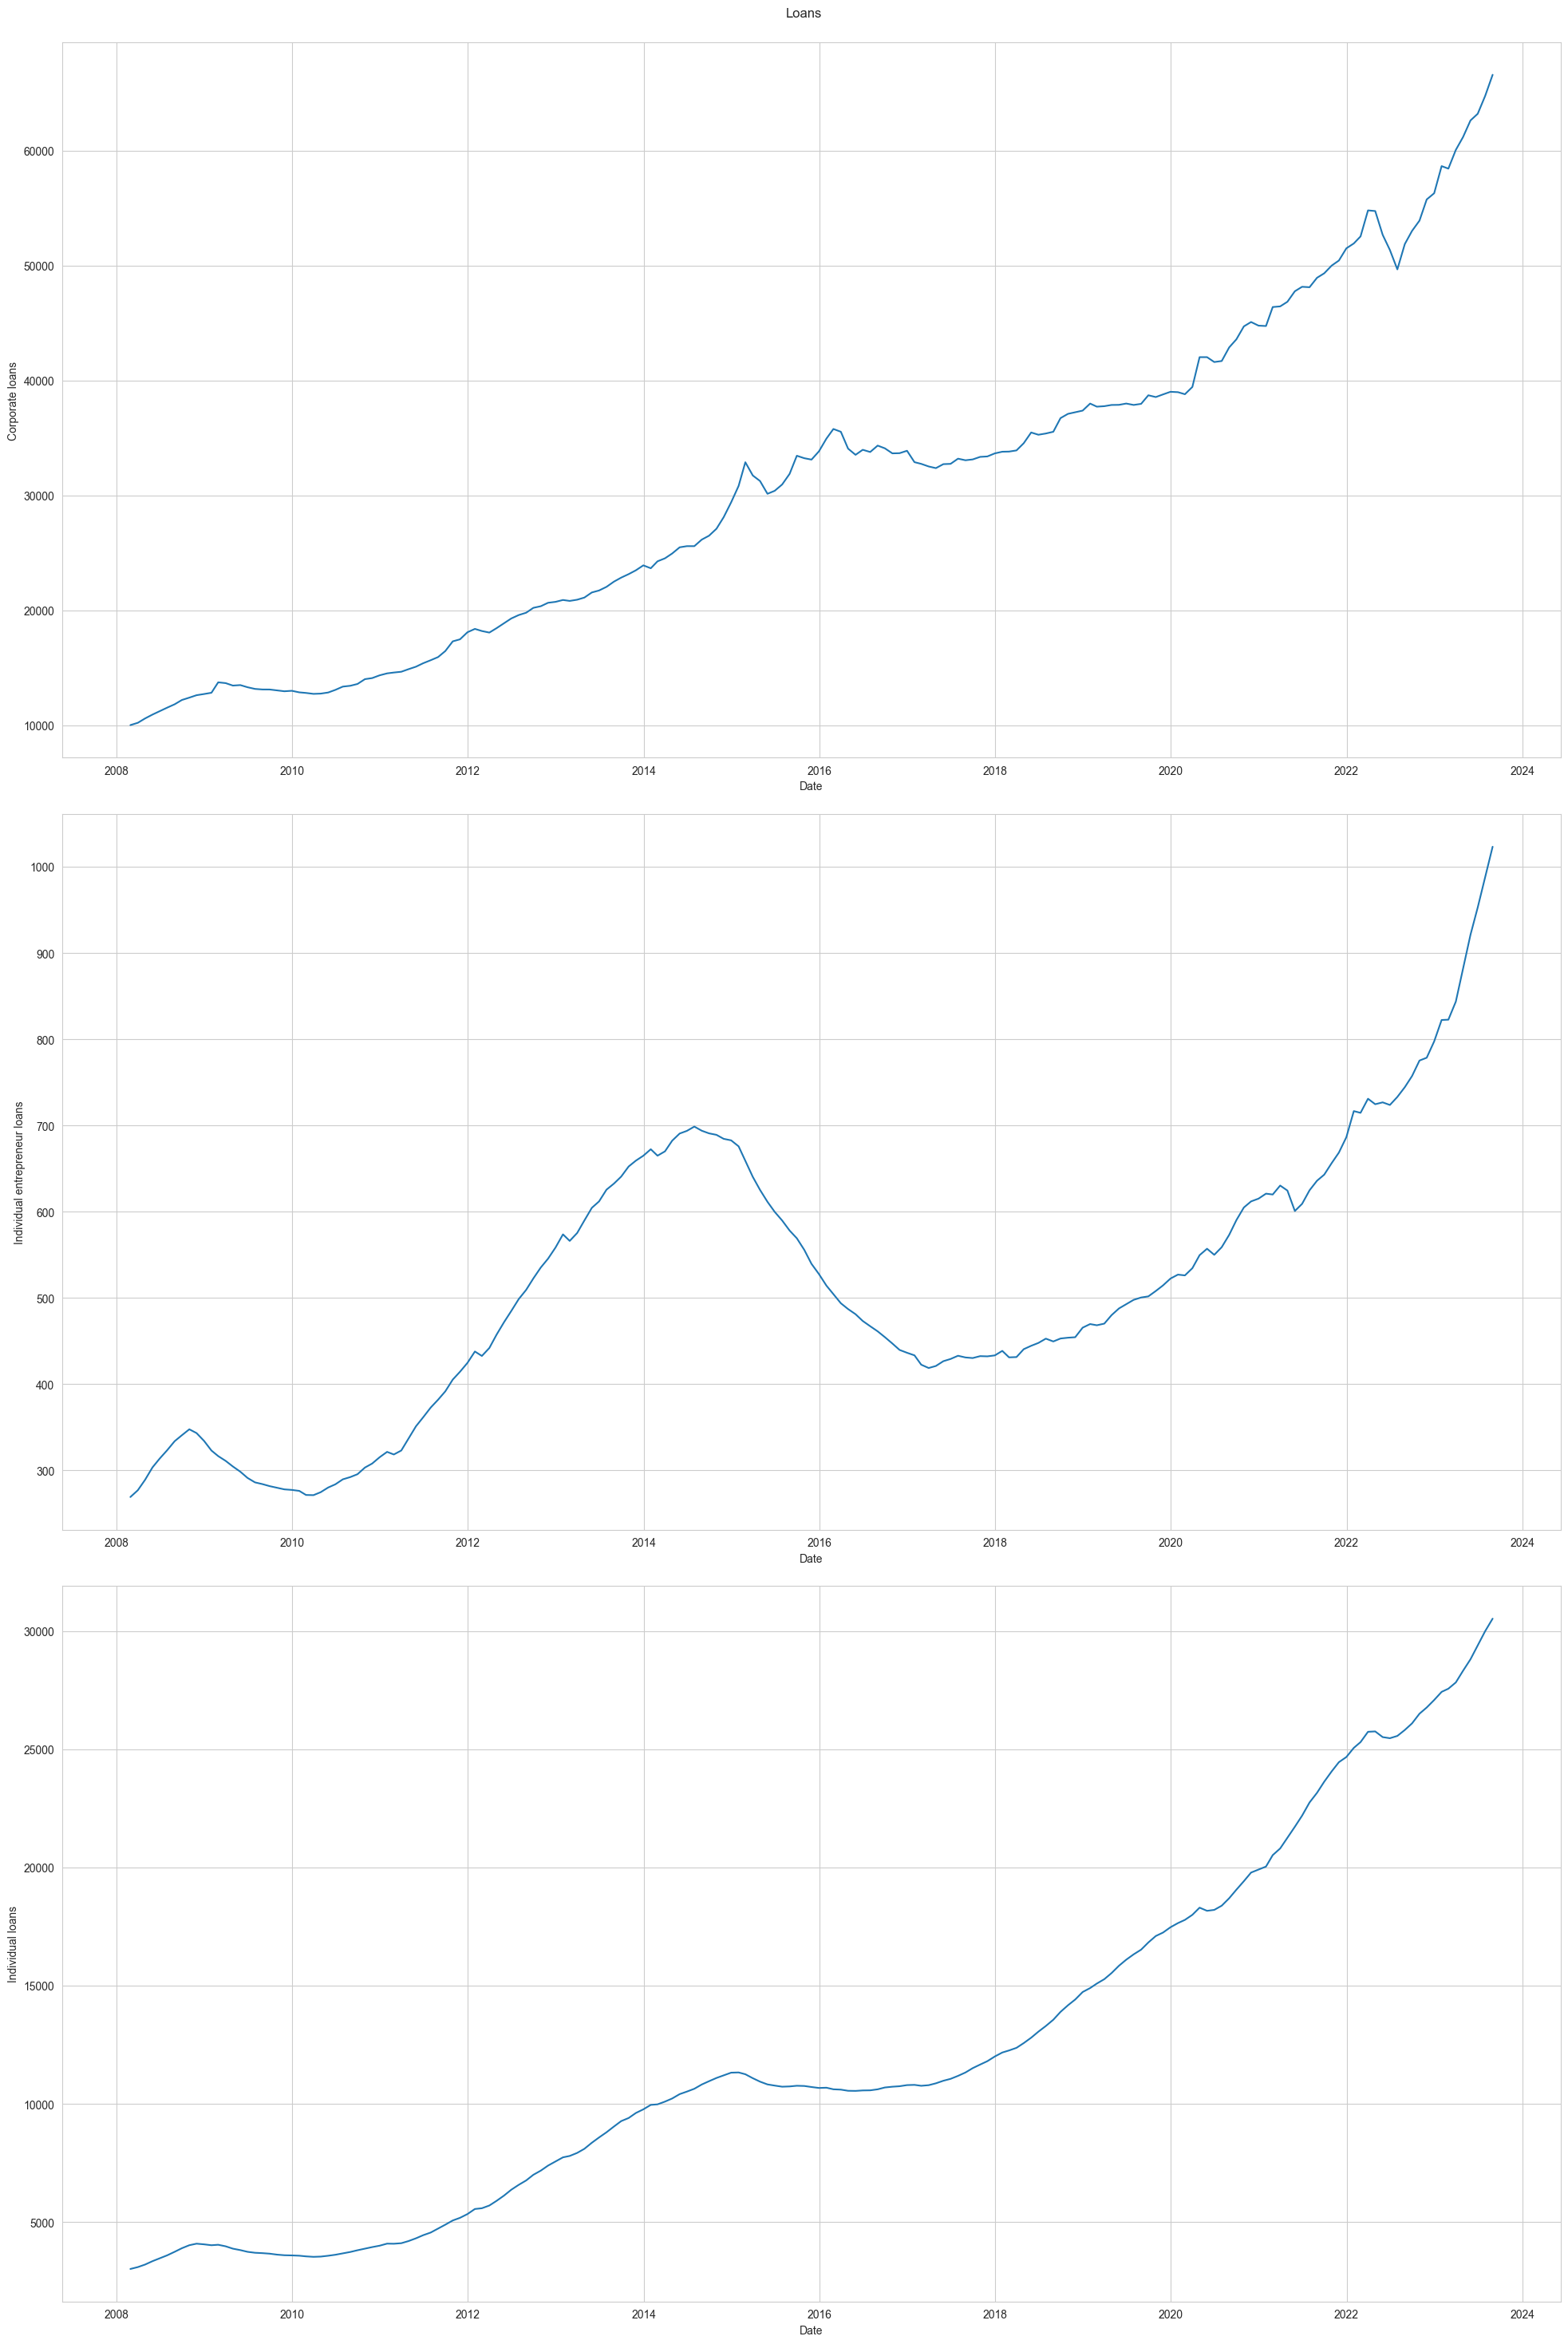

In [27]:
n_col = len(df_loans.columns)

fig, axes = plt.subplots(n_col, 1, figsize=(20, 10 * n_col))
fig.suptitle(f'Loans')
fig.tight_layout(pad=3.0)

# iterate all columns
for i, col in enumerate(df_loans.columns):
   sns.lineplot(data=df_loans[col], ax=axes[i])

All charts have an upward trend. There are no clearly visible data anomalies on the graphs. I think it makes sense to normalize the data for inflation as an experiment.
  
## 2.4 Exchange rates
As usual, we need to check that there are no NaN values and check descriptive statistics:

In [28]:
df_exchange_rates.isna().sum()

currency_pair
CNYRUB    0
EURRUB    0
USDRUB    0
dtype: int64

In [29]:
df_exchange_rates.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
currency_pair,,,,,,,,
CNYRUB,297.0,6.179438,3.091744,2.494000,3.514530,4.676754,9.147879,16.316073
EURRUB,297.0,50.174054,20.887819,23.758095,34.725224,40.552468,69.876505,114.181514
USDRUB,297.0,42.914286,19.217716,22.284737,28.529262,31.350214,62.620005,103.470045


The main observations:
1. There are no missing data and dates in the dataset.
2. All exchange rate values for mean and median differ by 20-30%, indicating the presence of outliers in the dataset.
3. However, the standard deviation is kept around 0.5 for all exchange rates.
4. Despite the 24 years of the data range, we have only 294 data points in the Exchange Rates dataset. It could be the main issue during the machine learning model training. 

Data visualisation:

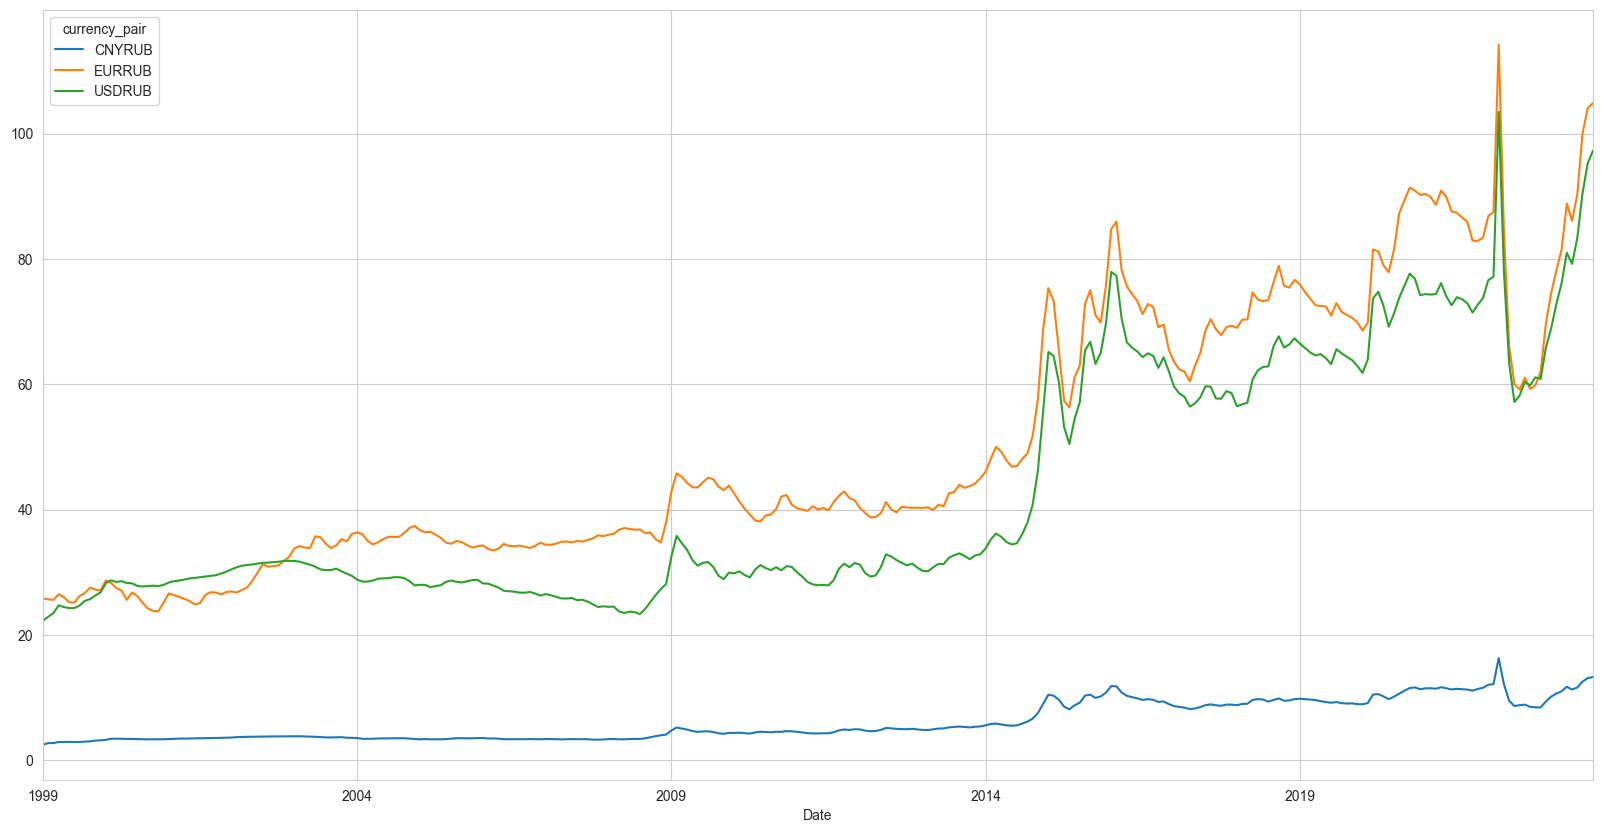

In [30]:
df_exchange_rates.plot();

Data visualization also revealed several features:
1. Like inflation, Exchange rates had strong fluctuations in the crisis years (2008-2009, 2014-2016, 2022-present).
2. All exchange rates are on an upward trend.

## 2.5 Key Rate, RUONIA, Interbank credit rate
As is standard practice, we need to verify that there are no NaN values:


In [31]:
df_kr_ruonia_mkr.isna().sum()

Key Ratio                    44
RUONIA                        0
RUONIA volume                 0
Moscow InterBank Rate         0
Moscow InterBank Turnover     0
dtype: int64

In [32]:
# Delete NAN values
df_kr_ruonia_mkr.dropna(inplace=True)

df_kr_ruonia_mkr.isna().sum()

Key Ratio                    0
RUONIA                       0
RUONIA volume                0
Moscow InterBank Rate        0
Moscow InterBank Turnover    0
dtype: int64

In [33]:
df_kr_ruonia_mkr.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Key Ratio,121.0,8.378380,2.839242,4.250000,6.964286,7.625000,10.000000,20.000000
RUONIA,121.0,8.350696,2.897924,3.990526,6.828636,7.648333,10.166316,19.975455
RUONIA volume,121.0,154.837240,94.097263,51.529500,102.587273,131.295238,166.363636,501.884000
Moscow InterBank Rate,121.0,8.366407,2.884596,4.049626,6.832643,7.667600,10.167733,19.814409
Moscow InterBank Turnover,121.0,231746.826082,72204.463919,130048.066190,184452.942957,213930.287350,260740.034545,492148.813440


The main observations:
1. There are 44 missing points for the Key Ratio. The reason of that the Centeral Bank of Russia introduced the Key Ratio only on September 13 in 2013 year. It significantly reduce our dataset.
2. The standardt deviation of the RUONIA volume is more than 0.5. Possibly the presence of outliners.
3. Other metrics have standard deviation about 20-30%, indicating good data quality.



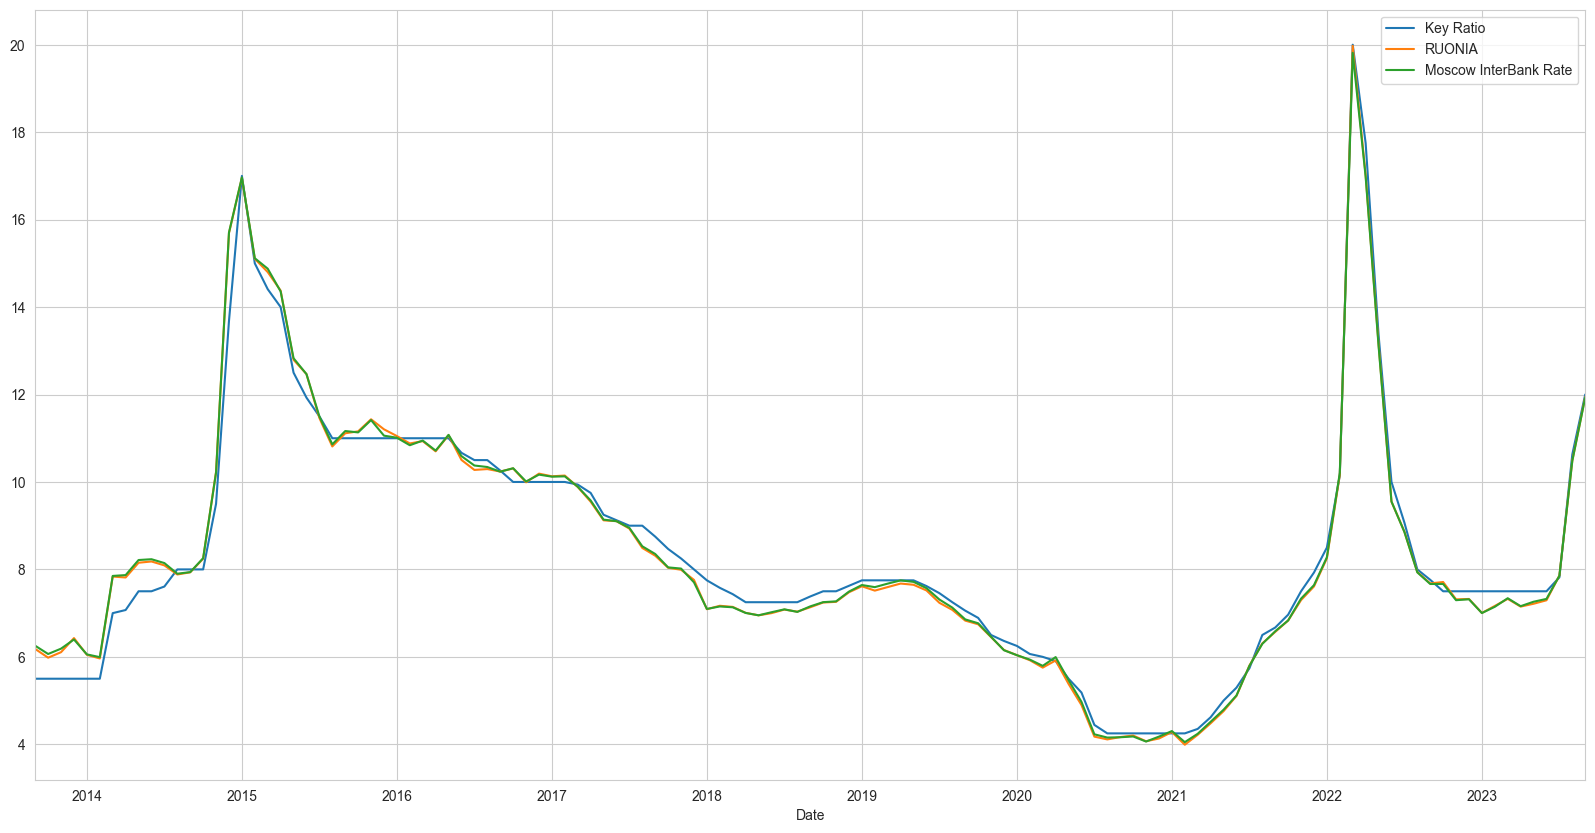

In [34]:
df_kr_ruonia_mkr.plot(y=['Key Ratio', 'RUONIA', 'Moscow InterBank Rate']);

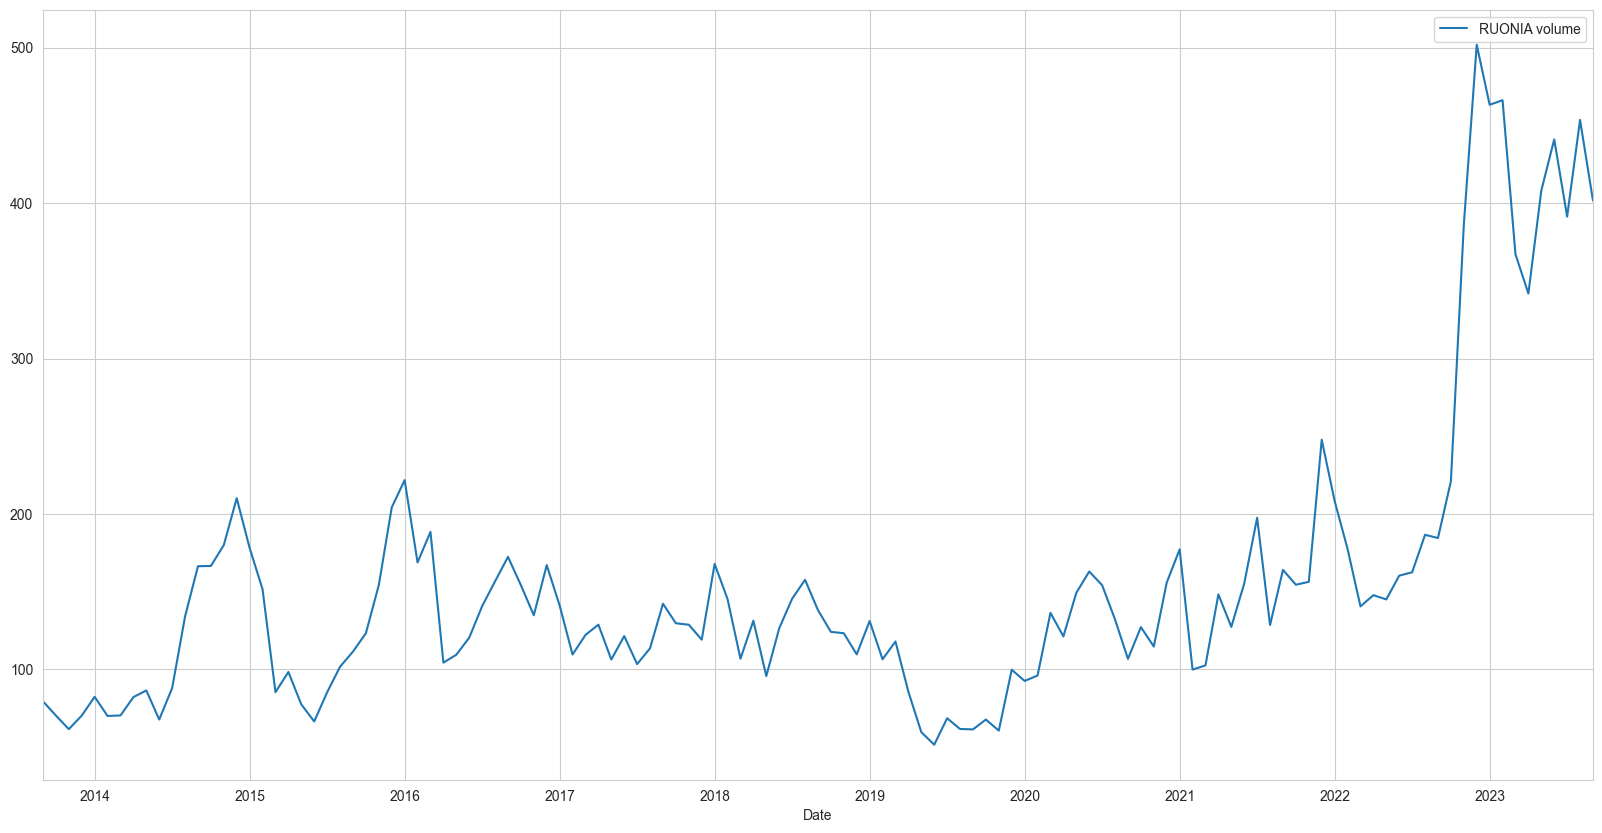

In [35]:
df_kr_ruonia_mkr.plot(y=['RUONIA volume']);

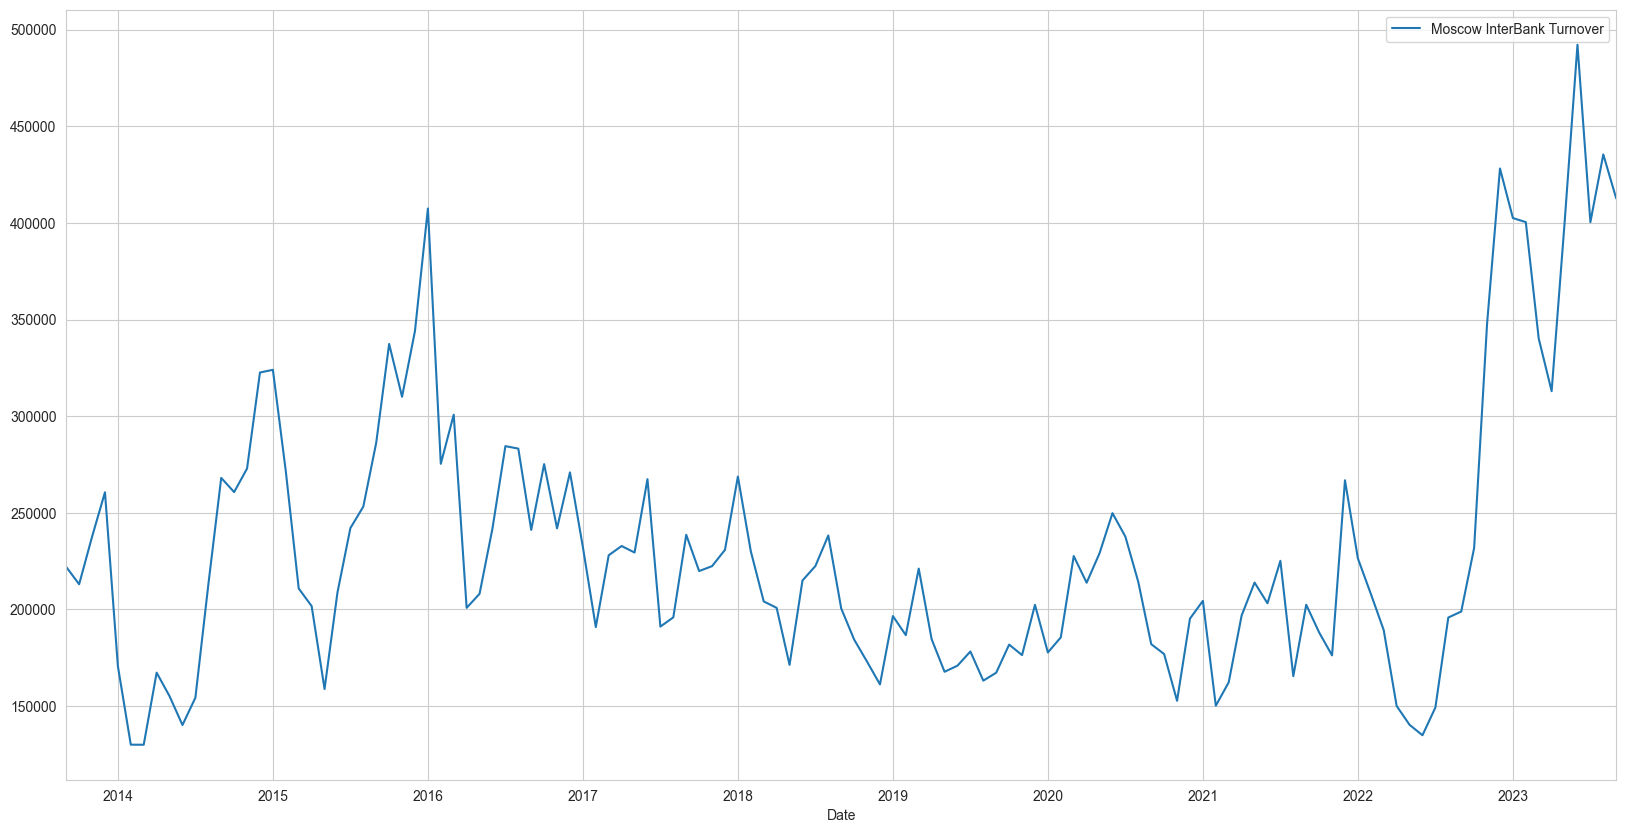

In [36]:
df_kr_ruonia_mkr.plot(y=['Moscow InterBank Turnover']);

The major obeservations:
1. The RUONIA and Interbank credit rates are interconnected and almost invariably repeat the Key Rate.
2. The Central Bank reacts with a strong increase in the key rate in times of crisis.
3. After the start of the Russian-Ukrainian conflict, the RUONIA and Interbank turnover is at elevated levels.

## 2.6 Average wages
Let check that the dataset doesn's have NA values and descriptive statistics.

In [37]:
df_wages.isna().sum()

Wages    0
dtype: int64

In [38]:
df_wages.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Wages,390.0,19639.622518,20124.219497,0.294,1394.5,12640.5,33633.75,88468.0


The main observations:
1. There is no missing data.
2. Standard deviation is 1.0 from the mean, which indicates that the data is not centered.

Data visualisation:

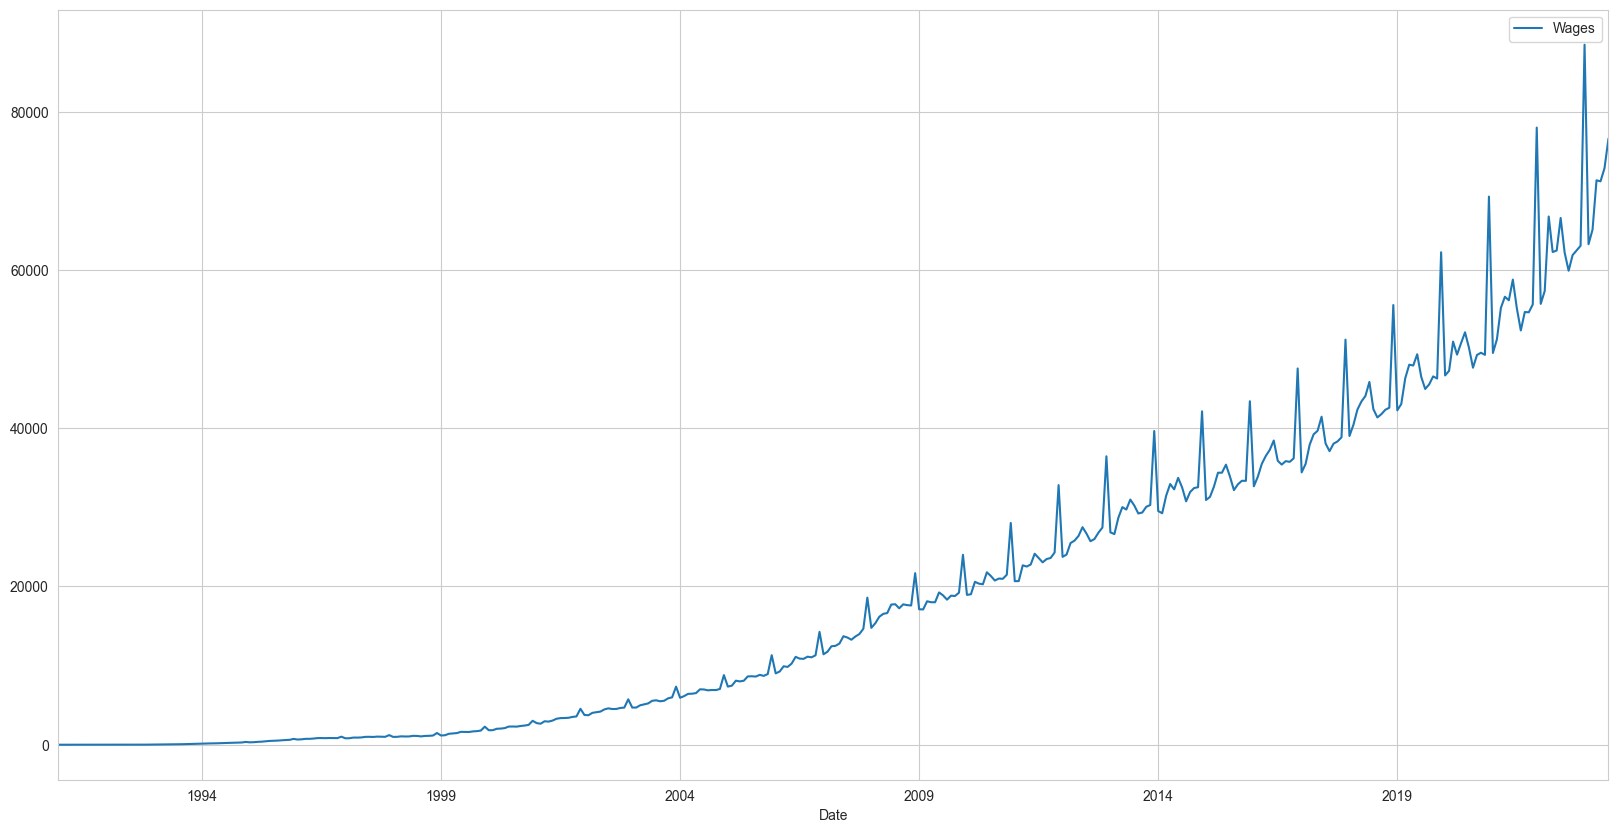

In [39]:
df_wages.plot();

The main obsevarions:
1. Average salaries are constantly rising, this is the main reason why the data is not centered.
2. Every year there is a jump in average salaries in December. This is due to bonuses at the end of the year.


# 3 Data preparation
The primary purpose of this section is to prepare data for training, validation, and model testing.  
In this section, I will: 
1. Combine all the features into a single data frame.
2. set the general model parameters,
3. prepare targets,
4. divide the whole dataset into training, validation, and test datasets,
5. normalize data.


## 3.1 Combine all features
I will combine all the features into a single pandas DataFrame to simplify the subsequent data processing.

In [196]:
# Merge all tables by index. All rows with NaN are dropped
df = pd.concat([df_sin, df_cpi_cleaned, df_exp_budget, df_loans, df_exchange_rates, df_kr_ruonia_mkr, df_wages], axis=1, join='outer')

# Prepare the output range
datetime_now = datetime.now()
output_range = pd.date_range(end=datetime_now, periods=OUTPUT_MONTHS, freq='1M', normalize=True)

# In the output range we need only CPI (labels) data
# Therefore, I can drop all NA in the DataFrame except output range
# and leave only CPI data in the output range
df = pd.concat([df.loc[~df.index.isin(output_range)].dropna(),
                df.loc[df.index.isin(output_range) & ~df.loc[:, 'CPI'].isna()]],
                axis=0)

In [197]:
# Verify that there no NA values in unexpected places
df.isna().sum()

Sin                              0
CPI                              0
Gov spending all                 1
Corporate loans                  0
Individual entrepreneur loans    0
Individual loans                 0
CNYRUB                           0
EURRUB                           0
USDRUB                           0
Key Ratio                        0
RUONIA                           0
RUONIA volume                    0
Moscow InterBank Rate            0
Moscow InterBank Turnover        0
Wages                            2
dtype: int64

This data is published with a delay of one quarter, and this is normal.

## 3.2 Prepare Targets (Shifted CPI)
Since I want the model to predict future CPI values, I must align current features with future inflation values (our targets). To accomplish this task, I will create a new column with CPI data and shift it back for several months. The current CPI value will also be used as samples.  
  
I will also prepare the dataset for preparing forecasts in future periods from the current date.

As a final step, I will also evaluate the descriptive statistics of the resulting dataset.

In [198]:
# Target and sample parameters
TARGET_COLUMN = 'CPI_shifted'
N_FEATURES = len(df.columns)

# Prepare targets - back-shifted CPI data
# Therefore, present data (the CPI included) will be used to forecast the future.
df[TARGET_COLUMN] = df['CPI'].shift(periods=-INPUT_MONTHS, freq='M')

# We do not have targets for the most recent targets, because we do not know 
# inflation in future periods. However, this data can be used to make 
# predictions for the future when our model is ready.
df_forecast = df.loc[df.loc[:, TARGET_COLUMN].isna(), :].copy()

# Drop rows where we do not have targets
df.dropna(inplace=True)

In [199]:
df.head(10)

,Sin,CPI,Gov spending all,Corporate loans,Individual entrepreneur loans,Individual loans,CNYRUB,EURRUB,USDRUB,Key Ratio,RUONIA,RUONIA volume,Moscow InterBank Rate,Moscow InterBank Turnover,Wages,CPI_shifted
2013-09-30,9.898214e-01,6.12,973.638538,22863.833705,640.716838,9270.501732,5.327400,43.483200,32.601670,5.500000,6.180455,79.455909,6.253636,222021.985000,29346.0,8.04
2013-10-31,9.096320e-01,6.25,1129.859430,23167.709261,652.410868,9401.594342,5.257922,43.747678,32.099226,5.500000,5.980870,70.309130,6.065652,213058.662174,30069.0,8.29
2013-11-30,5.406408e-01,6.49,1035.249401,23499.660266,659.189212,9613.944408,5.365754,44.152510,32.694000,5.500000,6.106842,61.536316,6.187895,237616.248947,30290.0,9.08
2013-12-31,1.224647e-16,6.47,2226.233798,23930.204490,664.905809,9768.007462,5.411896,45.028610,32.880705,5.500000,6.429524,70.251905,6.397273,260639.938636,39648.0,11.35
2014-01-31,-1.224647e-16,6.03,761.156476,23678.042484,672.408046,9957.094353,5.583935,46.058759,33.784353,5.500000,6.047059,82.335882,6.056471,170644.068824,29535.0,14.97
2014-02-28,-5.406408e-01,6.21,1500.387846,24282.046825,664.946715,9979.811037,5.800337,48.106415,35.244040,5.500000,5.963500,70.040500,5.993500,130068.293500,29255.0,16.71
2014-03-31,-9.096320e-01,6.92,1084.146135,24544.027560,669.983371,10095.896629,5.866744,50.031365,36.198565,7.000000,7.836190,70.351905,7.850952,130048.066190,31486.0,16.93
2014-04-30,-9.898214e-01,7.32,1280.524549,24964.323932,682.376354,10228.102035,5.732251,49.240768,35.667727,7.071429,7.815238,82.152857,7.870000,167316.501905,32947.0,16.41
2014-05-31,-7.557496e-01,7.58,780.169716,25500.773146,690.640186,10412.165820,5.583376,47.837295,34.833655,7.500000,8.152632,86.454737,8.214737,155153.432105,32272.0,15.78
2014-06-30,-2.817326e-01,7.80,995.725632,25602.198547,693.715477,10519.252343,5.525705,46.863083,34.449533,7.500000,8.181500,67.733500,8.233000,140228.355500,33726.0,15.27


In [200]:
df.tail(10)

,Sin,CPI,Gov spending all,Corporate loans,Individual entrepreneur loans,Individual loans,CNYRUB,EURRUB,USDRUB,Key Ratio,RUONIA,RUONIA volume,Moscow InterBank Rate,Moscow InterBank Turnover,Wages,CPI_shifted
2021-11-30,5.406408e-01,8.42,1806.272099,50458.386660,668.548396,24461.579437,11.378416,82.893421,72.698911,7.500000,7.298500,156.316500,7.332030,176267.160555,55639.0,11.98
2021-12-31,1.224647e-16,8.39,4821.168450,51520.288639,686.400350,24679.305841,11.583243,83.370783,73.769313,7.928571,7.610000,247.751000,7.639990,266847.845305,77994.0,11.94
2022-01-31,-1.224647e-16,8.76,1832.665350,51945.452204,716.660444,25067.579422,12.062100,86.836607,76.594747,8.500000,8.254706,208.314118,8.278753,226402.266494,55717.0,11.76
2022-02-28,-5.406408e-01,9.16,1835.518609,52557.981744,714.635713,25310.893947,12.156042,87.476853,77.169374,10.150000,10.166316,177.526842,10.209095,208128.271811,57344.0,10.97
2022-03-31,-9.096320e-01,16.68,2191.451219,54823.117690,731.010026,25748.059149,16.316073,114.181514,103.470045,20.000000,19.975455,140.522727,19.814409,189332.539359,66757.0,3.50
2022-04-30,-9.898214e-01,17.84,3009.767528,54765.581639,724.630770,25763.397349,12.142441,84.352759,77.899186,17.750000,17.020500,147.750000,16.980870,150103.437410,62269.0,2.31
2022-05-31,-7.557496e-01,17.11,1584.249694,52696.827306,726.801691,25522.978770,9.491783,65.973324,63.312741,13.368421,13.158421,145.022105,13.116963,140354.960658,62457.0,2.50
2022-06-30,-2.817326e-01,15.89,2081.144022,51375.543669,723.767731,25475.969788,8.675162,60.007443,57.178557,10.000000,9.549524,160.307619,9.552929,134941.244324,66572.0,3.25
2022-07-31,2.817326e-01,15.09,2682.120186,49688.585543,733.105398,25572.932343,8.793905,59.169236,58.221400,9.071429,8.865238,162.466667,8.856500,149303.035667,62200.0,4.30
2022-08-31,7.557496e-01,14.30,2097.784840,51893.580983,744.409559,25824.601346,8.890038,61.041973,60.391918,8.000000,7.940435,186.600000,7.932883,195842.130726,59907.0,5.12


In [201]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Sin,108.0,-2.981154e-17,0.680159,-0.989821,-0.594418,0.000000,0.594418,0.989821
CPI,108.0,7.021574e+00,4.395900,2.200000,3.810000,5.890000,8.090000,17.840000
Gov spending all,108.0,1.559995e+03,655.608737,693.611310,1145.198143,1368.542715,1724.015049,4821.168450
Corporate loans,108.0,3.690453e+04,7955.892722,22863.833705,32764.139920,35128.967972,41797.530652,54823.117690
Individual entrepreneur loans,108.0,5.584852e+02,101.112066,418.702883,459.547500,549.764473,653.393607,744.409559
Individual loans,108.0,1.489796e+04,5090.608680,9270.501732,10763.166091,12316.096080,18233.631960,25824.601346
CNYRUB,108.0,9.403188e+00,1.873951,5.257922,8.793066,9.538463,10.488761,16.316073
EURRUB,108.0,7.126640e+01,13.162412,43.483200,64.615283,72.379304,78.916642,114.181514
USDRUB,108.0,6.190342e+01,12.858334,32.099226,57.733031,64.325853,70.637258,103.470045
Key Ratio,108.0,8.408088e+00,2.966219,4.250000,6.500000,7.750000,10.000000,20.000000


The main observations:
1. The median and mean values are approximately equal for all samples.
2. The standard deviation is less than the mean but still significant for СPI, Target Shifted CPI, Individual Loans, and Budget Expenditure.
3. The data set has been significantly reduced: 10 years and only 134 data points. Given that I will split the dataset to train, val, and test datasets, there will be very little data for training the model.

## 3.3 Tensorflow Dataset preparation
I used tf.data.Dataset class to store and feed dataset to the model.
I mainly used the Tensorflow Time series windowing article during the preparation [4][5][6] 

In [46]:
class WindowGen():
    """The generator of data windows for train, validation and test datasets.
    """
    def __init__(self, *,
                 input_window: int,
                 output_window: int,
                 batch_size: int,
                 df: pd.DataFrame,
                 label_columns: list,
                 backtesting_type: str,
                 total_folds: int,
                 fold_number: int = 0,
                 train_ratio: float,
                 val_ratio: float,
                 ):
        """A constructor to initialize a new WindowGen object.
        Parameters
        ----------
        input_window: int
            The number of elements from the dataset that will be used to create
            the running window of samples. 

        output_window: int
            The number of elements from the dataset that will be used to create
            the running window of labels.

        batch_size: int
            The size of the batch to train the model.

        df: pandas.DataFrame
            The pandas DataFrame that contains dataset.

        label_columns: list
            The list that contains DataFrames columns that will be used as
            labels.

        backtesting_type: str
            The backtesting approch used to generate data. The following
            methods are supported:
            refit_increase - backtesting with refit and increasing training
                             size.
            refit_fixed - backtesting with refit and fixed training size.
            no_refit - backtesting without refit.

        total_folds: int
            The total number of folds to be created.

        fold_number: int
            The dataset will be prepared for the specified fold number.

        train_ratio: float
            The share of the dataset allocated for the model training. 

        val_ratio: float
            The share of the dataset allocated for the model validation. Note
            that the validation dataset will be split between all folds. Also,
            validation data will always be more recent than training data.
        """

        # ASSERTIONS
        # Type Errors
        if not isinstance(input_window, int):
            raise TypeError(f'input_window must be an int, not '
                            f'{type(input_window)}')

        if not isinstance(output_window, int):
            raise TypeError(f'output_window must be an int, not '
                            f'{type(output_window)}')

        if not isinstance(batch_size, int):
            raise TypeError(f'batch_size must be an int, not '
                            f'{type(batch_size)}')

        if not isinstance(df, pd.DataFrame):
            raise TypeError(f'df must be a pandas DataFrame, not {type(df)}')

        if not isinstance(label_columns, list):
            raise TypeError(f'label_columns must be a list, not '
                            f'{type(label_columns)}')
    
        if any(not isinstance(x, str) for x in label_columns):
            raise TypeError('label_columns must contains only strings')

        if not isinstance(backtesting_type, str):
            raise TypeError(f'backtesting_type must be a string, not '
                            f'{type(backtesting_type)}')

        if not isinstance(total_folds, int):
            raise TypeError(f'total_folds must be int, not '
                            f'{type(total_folds)}')
        
        if not isinstance(fold_number, int):
            raise TypeError(f'fold_number must be int, not '
                            f'{type(fold_number)}')

        if not isinstance(train_ratio, float):
            raise TypeError(f'train_ratio must be a float, not '
                            f'{type(train_ratio)}')

        if not isinstance(val_ratio, float):
            raise TypeError(f'val_ratio must be a float, not '
                            f'{type(val_ratio)}')

        # Value Errors
        if input_window < 0:
            raise ValueError('input_window must be above zero')

        if output_window < 0:
            raise ValueError('output_window must be above zero')

        if batch_size < 0:
            raise ValueError('batch_size must be above zero')

        if len(df) < (input_window + output_window):
            raise ValueError('df contains not enough data rows to generate'
                             'sample and lable running windows')
        
        if len(label_columns) < 0:
            raise ValueError('label_columns must contain at least one field')

        if any(not x in df.columns for x in label_columns):
            raise ValueError('The DataFrame df must contain all columns from '
                             'label_columns')

        if backtesting_type not in ['refit_increase', 'refit_fixed',
                                    'no_refit']:
            raise ValueError('Not supported backstaging type')

        if total_folds < 0:
            raise ValueError('total_folds must be above or equal to 0')

        if fold_number < 0:
            raise ValueError('total_folds must be above or equal to 0')

        if total_folds != 0 and fold_number > total_folds - 1:
            raise ValueError('The fold_number is above total_folds')

        if train_ratio < 0.0:
            raise ValueError('train_ratio must be above or equal to zero')

        if val_ratio < 0.0:
            raise ValueError('val_ratio must be above or equal to zero')

        if train_ratio + val_ratio > 1.0:
            raise ValueError('train_ratio and val_ratio should not take up'
                             'more than the full dataset')

        # Save variables
        self.input_window = input_window
        self.output_window = output_window
        self.batch_size = batch_size
        self.df_orig = df.copy()
        self.df = df.copy()
        self.label_columns = label_columns
        self.backtesting_type = backtesting_type
        self.total_folds = total_folds
        self.fold_number = fold_number
        self.n_train = int(len(df) * train_ratio)
        self.n_val = int(len(df) * val_ratio)
        self.n_test = None

        # Prepare train, val and test dataset indices 
        self.df_train_ind = None
        self.df_val_ind = None
        self.df_test_ind = None
        self.__prepare_indices()

        # Data normalisation
        self.train_mean = None
        self.train_std = None
        self.__data_normalisation()
        
        # Compute sample columns, number of features, number of labels
        self.sample_columns = [col for col in df.columns if col not in label_columns]
        self.n_features = len(self.sample_columns)
        self.n_labels = len(self.label_columns)

        # Compute the sample and label column indices.
        self.label_columns_indices = [i for i, col in enumerate(df.columns) if col in self.label_columns]
        self.sample_column_indices = [i for i, col in enumerate(df.columns) if col in self.sample_columns]


    def __prepare_indices(self):
        """Prepare train, validation and test dataset indices."""

        # Prepare validation indices if any
        if self.total_folds != 0 and self.n_val != 0:
            # The number of validation items per fold and range of val items
            d = int(self.n_val / self.total_folds)

            # Update the number of items of the validation dataset
            self.n_val = self.total_folds * d
        
            # Prepare and split into folds validation indices
            self.df_val_ind = [self.df.index[self.n_train + i*d:self.n_train + (i+1)*d]
                               for i in range(self.total_folds)]

        # Prepare test indices
        self.df_test_ind = self.df.index[self.n_train + self.n_val:]
        self.n_test = self.df_test_ind.shape[0]

        # Prepare train indices
        self.__prepare_train_indices()

    def __prepare_train_indices(self):
        """Prepare train indices. The train indices strongly depends on the backstaging test type."""

        # Prepare base train dataset indices
        self.df_train_ind = self.df.index[:self.n_train]

        if self.total_folds != 0 and self.n_val != 0:
            # Backtesting with refit and increasing training size. The unused validation set on the left is added to the training set
            if self.backtesting_type == 'refit_increase':
                for i in range(self.fold_number):
                    self.df_train_ind = self.df_train_ind.union(self.df_val_ind[i])

                # Update the number of train items
                self.n_train = len(self.df_train_ind)

            elif self.backtesting_type == 'refit_fixed':
                pass
            elif self.backtesting_type == 'no_refit':
                pass

    def __data_normalisation(self):
        """Normalise data in DataFrames based on the train dataset."""

        # Restore denormalised data
        self.df = self.df_orig.copy()

        # Prepare mean and standard deviation values based on the train dataset
        self.train_mean = self.df.loc[self.df_train_ind].mean()
        self.train_mean.loc[self.label_columns] = self.train_mean.loc['CPI']
        self.train_std = self.df.loc[self.df_train_ind].std()
        self.train_std.loc[self.label_columns] = self.train_std.loc['CPI']

        # Normalise dataset
        self.df = (self.df - self.train_mean) / self.train_std

    def __repr__(self):
        return '\n'.join([
            f'Input Window: {self.input_window}',
            f'Output Window: {self.output_window}',
            f'Total Folds: {self.total_folds}',
            f'Current fold number: {self.fold_number}',
            f'Batch size: {self.batch_size}',
            f'All items in DataFrame: {len(self.df)}',
            f'Train items: {self.n_train}',
            f'Val All items: {self.n_val}',
            f'Val Fold items: {len(self.df_val_ind[self.fold_number]) if self.df_val_ind is not None else None}',
            f'Test items: {self.n_test}',
            f'Sample column indices: {self.sample_column_indices}',
            f'Sample column name(s): {self.sample_columns}',
            f'Label column indices: {self.label_columns_indices}',
            f'Label column name(s): {self.label_columns}',
        ])

    def make_dataset(self, indices: pd.DatetimeIndex) -> tf.data.Dataset:
        """Transform pandas DataFrame to TensorFlow dataset.

        The dataset will be split into the (dataset length - input window + 1) containers.

        Example:
        Dataset Items = 7 | Input window width = 5 | Output window width = 3 | Number of windows = 7 - 5 + 1 = 3
        Input window 0: 0 - 4 | Output window 0: 0 - 2
        Input window 1: 1 - 5 | Output window 0: 1 - 3
        Input window 2: 2 - 6 | Output window 0: 2 - 4

        Parameters
        ----------
        indices: pandas.DatetimeIndex
            The DataFrame indices to filter out the DataFrame.

        Returns:
        __________
        TensorFlow dataset on Success, or None.
        """

        # Slice Pandas Dataframe by indices
        df = self.df.loc[indices]

        # Calculate the number of windows
        if (number_of_windows := len(df) - self.input_window + 1) >= 1:
            pass
            # number_of_windows = len(df) - self.input_window + 1
        # Not enough data to fill the window
        else:
            raise AssertionError('Not enough data to fill the window')

        # Create containers for samples and labels
        X = np.zeros((number_of_windows, self.input_window, self.n_features), dtype=np.float64)
        y = np.zeros((number_of_windows, self.output_window, self.n_labels), dtype=np.float64)

        # Iterate all window containers and fill them by data from pandas DataFrame
        for i in range(number_of_windows):
            X_window = df.iloc[i:i + self.input_window, self.sample_column_indices].to_numpy(dtype=np.float64)
            y_window = df.iloc[i:i + self.output_window, self.label_columns_indices].to_numpy(dtype=np.float64)

            # Check that DataFrame has enough data to fill the input window
            # if not enough, add additional rows filled by zeros
            if len(X_window) < self.input_window:
                zero_values = np.zeros((self.input_window - len(X_window), self.n_features))
                X_window = np.vstack([X_window, zero_values])

            if len(y_window) < self.output_window:
                zero_values = np.zeros((self.input_window - len(X_window), self.n_features))
                y_window = np.vstack([y_window, zero_values])

            # Fill the window array by data from DataFrame
            X[i] = X_window
            y[i] = y_window

        # Transform numpy ndarray to Tensorflow dataset
        ds_x = tf.data.Dataset.from_tensor_slices(X)
        ds_y = tf.data.Dataset.from_tensor_slices(y)

        # Zip sample and labels datasets
        ds = tf.data.Dataset.zip((ds_x, ds_y))

        # Divide dataset into batches by batch size
        return ds.batch(self.batch_size)

    def set_fold_number(self, fold_number: int):
        """Set a new fold number."""
        # ASSERTIONS
        if not isinstance(fold_number, int):
            raise TypeError(f'fold_number must be int, not {type(fold_number)}')

        if fold_number < 0:
            raise ValueError('total_folds must be above or equal to 0')

        if self.total_folds == 0:
            raise ValueError('There are no folds. total_folds is zero')

        if fold_number > self.total_folds - 1:
            raise ValueError('The fold_number is above total_folds')

        # Check that the fold number is changed
        if fold_number != self.fold_number:
            # Update the fold number
            self.fold_number = fold_number

            # Update train indices
            self.__prepare_train_indices()

            # Train data is changed. Therefore need to update normsalisation
            self.__data_normalisation()

    @property
    def train(self) -> tf.data.Dataset:
        """Prepare the train Tensorflow dataset divided by windows."""
        return self.make_dataset(self.df_train_ind)

    @property
    def val(self) -> tf.data.Dataset:
        """Prepare the validation Tensorflow dataset divided by windows."""
        return self.make_dataset(self.df_val_ind[self.fold_number])

    @property
    def test(self) -> tf.data.Dataset:
        """Prepare the test Tensorflow dataset divided by windows."""
        return self.make_dataset(self.df_test_ind)

In [47]:
ds = WindowGen(input_window=INPUT_MONTHS,
               output_window=OUTPUT_MONTHS,
               batch_size=16,
               df=df,
               label_columns=['CPI_shifted'],
               backtesting_type='refit_increase',
               total_folds=3,
               fold_number=0,
               train_ratio=0.55,
               val_ratio=0.35,
               )

ds

Input Window: 12
Output Window: 12
Total Folds: 3
Current fold number: 0
Batch size: 16
All items in DataFrame: 108
Train items: 59
Val All items: 36
Val Fold items: 12
Test items: 13
Sample column indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Sample column name(s): ['Sin', 'CPI', 'Gov spending all', 'Corporate loans', 'Individual entrepreneur loans', 'Individual loans', 'CNYRUB', 'EURRUB', 'USDRUB', 'Key Ratio', 'RUONIA', 'RUONIA volume', 'Moscow InterBank Rate', 'Moscow InterBank Turnover', 'Wages']
Label column indices: [15]
Label column name(s): ['CPI_shifted']

# 4. Build the Neural Network model
In this section, I will be concentrating on constructing various neural network architectures for the purpose of training and comparing their performance. The central theme of these architectures is to have a structure that consists of an input layer followed by a series of recurrent layers, specifically GRU (Gated Recurrent Units) or LSTM (Long Short-Term Memory) layers, which then proceed to a dense layer and culminate in an output layer. By implementing this approach, I aim to investigate the effectiveness of these architectural choices and determine which configuration provides the most promising results.

In [48]:
def create_model(
        *, input_window: int,
        n_features: int,
        output_window: int,
        layer_types: list[str],
        layer_units: list[int],
        activations: list[str | None],
        recurrent_activations: list[str | None],
        kernel_regulizers: list[keras.regularizers.L2 | keras.regularizers.L1 | keras.regularizers.L1L2 | None],
        recurrent_regularizers: list[keras.regularizers.L2 | keras.regularizers.L1 | keras.regularizers.L1L2 | None],
        bias_regularizers: list[keras.regularizers.L2 | keras.regularizers.L1 | keras.regularizers.L1L2 | None],
        activity_regulizers: list[keras.regularizers.L2 | keras.regularizers.L1 | keras.regularizers.L1L2 | None],
        dropouts: list[float],
        recurrent_dropouts: list[float],
        output_kernel_regularizer: keras.regularizers.L2 | keras.regularizers.L1 | keras.regularizers.L1L2 | None,
        output_bias_regularizer: keras.regularizers.L2 | keras.regularizers.L1 | keras.regularizers.L1L2 | None,
        output_activity_regularizer: keras.regularizers.L2 | keras.regularizers.L1 | keras.regularizers.L1L2 | None,
        optimizer: tf.keras.optimizers.Optimizer,
):
    """Create and compile the TensofFlow model.

    Parameters:
    __________
    input_window: int
        The number of elements from the dataset that will be used to create
        the running window of samples.

    n_features: int
        The number of features in the input dataset.

    output_window: int
        The number of elements from the dataset that will be used to create
        the running window of labels.

    layer_types: list[str]
        The layers types that will be used to construct the model.
        Supported layers:
        gru - GRU(Gated Recurrent Unit)
        lstm - LSTM(Long short-term memory)

    layer_units: list[int]
        The list of dimensionality of the output space of each layer.

    activations: list[str]
        Activation functions to use.

    recurrent_activations: list[str]
        Activation functions to use for the recurrent step.

    kernel_regulizers: list[keras.regularizers.L2 | keras.regularizers.L1 | None]
        The list of regularizer functions applied to the kernel weights matrix. Default: None.

    recurrent_regularizers: list[keras.regularizers.L2 | keras.regularizers.L1 | None]
        The list of regularizer functions applied to the recurrent_kernel weights matrix. Default: None.

    bias_regularizers: list[keras.regularizers.L2 | keras.regularizers.L1 | None]
        The list of regularizer function applied to the bias vector. Default: None.

    activity_regulizers: list[keras.regularizers.L2 | keras.regularizers.L1 | None]
        The list of regularizer functions applied to the output of the layer (its "activation"). Default: None.

    dropouts: list[float]
        The list of floats between 0 and 1. Fraction of the units to drop for the linear transformation of the inputs. Default: 0.

    recurrent_dropouts: list[float]
        The list of floats between 0 and 1. Fraction of the units to drop for the linear transformation of the recurrent state. Default: 0.

    output_kernel_regularizer: keras.regularizers.L2 | keras.regularizers.L1 | None
        A regularizer function applied to the kernel weights matrix. Default: None.

    output_bias_regularizer: keras.regularizers.L2 keras.regularizers.L1 | None
        A regularizer function applied to the bias vector. Default: None.

    output_activity_regularizer: keras.regularizers.L2 | keras.regularizers.L1 | None
        A regularizer function applied to the output of the layer (its "activation"). Default: None.

    optimizer: tf.keras.optimizers.Optimizer
        The optimizer.

    Returns:
    _______
    Constructed and compiled TensorFlow model on Success, or None.
    """

    # ASSERTIONS
    SUPPORTED_LAYER_TYPES = ['gru', 'lstm']
    SUPPORTED_REGULIZERS = (keras.regularizers.L1, keras.regularizers.L2, keras.regularizers.L1L2)
    # Type Errors
    if not isinstance(input_window, int):
        raise TypeError(f'input_window must be an integer, not {type(input_window)}')

    if not isinstance(n_features, int):
        raise TypeError(f'n_features must be an integer, not {type(n_features)}')

    if not isinstance(output_window, int):
        raise TypeError(f'output_window must be an integer, not {type(output_window)}')

    if not isinstance(layer_types, list):
        raise TypeError(f'layer_types must be a list, not {type(layer_types)}')

    if any(not isinstance(lt, str) for lt in layer_types):
        raise TypeError('all layer types must be str')

    if not isinstance(layer_units, list):
        raise TypeError(f'layer_units must be a list, not {type(layer_units)}')

    if any(not isinstance(lu, int) for lu in layer_units):
        raise TypeError('all layer units must be int')

    if not isinstance(activations, list):
        raise TypeError(f'activations must be a list, not {type(activations)}')

    if any(not isinstance(a, str) for a in activations):
        raise TypeError('all activation functions must be str')

    if not isinstance(recurrent_activations, list):
        raise TypeError(f'recurrent_activation must be a list, not {type(recurrent_activations)}')

    if any(not isinstance(ra, str) for ra in recurrent_activations):
        raise TypeError('all recurrent activation functions must be str')

    if not isinstance(kernel_regulizers, list):
        raise TypeError(f'kernel_regulizers must be a list, not {type(kernel_regulizers)}')

    if any(not (kr is None or isinstance(kr, SUPPORTED_REGULIZERS)) for kr in kernel_regulizers):
        raise TypeError('All kernel_regulizers must be L2 regulizers or None')

    if not isinstance(recurrent_regularizers, list):
        raise TypeError(f'recurrent_regularizers must be a list, not {type(recurrent_regularizers)}')

    if any(not (rr is None or isinstance(rr, SUPPORTED_REGULIZERS)) for rr in recurrent_regularizers):
        raise TypeError('All recurrent_regularizers must be L2 regulizers')

    if not isinstance(bias_regularizers, list):
        raise TypeError(f'bias_regularizers must be a list, not {type(bias_regularizers)}')

    if any(not (br is None or isinstance(br, SUPPORTED_REGULIZERS)) for br in bias_regularizers):
        raise TypeError('All bias_regularizers must be L2 regulizers')

    if not isinstance(activity_regulizers, list):
        raise TypeError(f'bias_regularizers must be a list, not {type(activity_regulizers)}')

    if any(not (ar is None or isinstance(ar, SUPPORTED_REGULIZERS)) for ar in activity_regulizers):
        raise TypeError('All activity_regulizers must be L2 regulizers')

    if not isinstance(dropouts, list):
        raise TypeError(f'dropout must be a list, not {type(dropouts)}')

    if any(not isinstance(d, float) for d in dropouts):
        raise TypeError('All dropouts must be floats')

    if not isinstance(recurrent_dropouts, list):
        raise TypeError(f'recurrent_dropout must be a list, not {type(recurrent_dropouts)}')

    if any(not isinstance(rd, float) for rd in recurrent_dropouts):
        raise TypeError('All recurrent dropouts must be floats')

    if output_kernel_regularizer is not None and not isinstance(output_kernel_regularizer, SUPPORTED_REGULIZERS):
        raise TypeError(f'output_kernel_regularizer must be keras.regularizers, not {type(output_kernel_regularizer)}')

    if output_bias_regularizer is not None and not isinstance(output_bias_regularizer, SUPPORTED_REGULIZERS):
        raise TypeError(f'output_bias_regularizer must be keras.regularizers, not {type(output_bias_regularizer)}')

    if output_activity_regularizer is not None and not isinstance(output_activity_regularizer, SUPPORTED_REGULIZERS):
        raise TypeError(f'output_activity_regularizer must be keras.regularizers, not {type(output_activity_regularizer)}')

    # Value Errors
    if input_window <= 0:
        raise ValueError('input_window must be above zero')

    if n_features <= 0:
        raise ValueError('n_features must be above zero')

    if output_window <= 0:
        raise ValueError('output_window must be above zero')

    if any(lt not in SUPPORTED_LAYER_TYPES for lt in layer_types):
        raise ValueError(f'The layer types must be one of {SUPPORTED_LAYER_TYPES}')

    if any(lu <= 0 for lu in layer_units):
        raise ValueError(f'The layer units must be above zero')

    if any(d < 0 or d > 1 for d in dropouts):
        raise ValueError('All dropouts must be between zero and one')

    if any(rd < 0 or rd > 1 for rd in recurrent_dropouts):
        raise ValueError('All recurrent dropout must be between zero and one')

    if len(layer_types) != len(layer_units) != len(activations) != len(recurrent_activations) != len(kernel_regulizers) != len(activity_regulizers) != len(recurrent_regularizers) != len(bias_regularizers) != len(dropouts) != len(recurrent_dropouts):
        raise ValueError('All lists must have the same number of items')

    # =======================================================================
    # Model layers
    input_tensor = keras.Input(shape=(input_window, n_features),
                               dtype='float32',
                               name=f'input')
    x = input_tensor

    # Iterate all layers
    for layer_n, layer_type in enumerate(layer_types):
        # GRU layer
        if layer_type == 'gru':
            layer = tf.keras.layers.GRU(
                units=layer_units[layer_n],
                activation=activations[layer_n],
                recurrent_activation=recurrent_activations[layer_n],
                kernel_regularizer=kernel_regulizers[layer_n],
                recurrent_regularizer=recurrent_regularizers[layer_n],
                bias_regularizer=bias_regularizers[layer_n],
                activity_regularizer=activity_regulizers[layer_n],
                dropout=dropouts[layer_n],
                recurrent_dropout=recurrent_dropouts[layer_n],
                return_sequences=True if (len(layer_types) - layer_n - 1) else False,
                dtype='float32',
                name=f'gru_{layer_n}',
            )

        # LSTM layer
        elif layer_type == 'lstm':
            layer = tf.keras.layers.LSTM(
                units=layer_units[layer_n],
                activation=activations[layer_n],
                recurrent_activation=recurrent_activations[layer_n],
                kernel_regularizer=kernel_regulizers[layer_n],
                recurrent_regularizer=recurrent_regularizers[layer_n],
                bias_regularizer=bias_regularizers[layer_n],
                activity_regularizer=activity_regulizers[layer_n],
                dropout=dropouts[layer_n],
                recurrent_dropout=recurrent_dropouts[layer_n],
                return_sequences=True if (len(layer_types) - layer_n - 1) else False,
                dtype='float32',
                name=f'lstm_{layer_n}',
            )

        x = layer(x)



    ouput_dense = tf.keras.layers.Dense(
        OUTPUT_MONTHS * 1,
        activation=None,
        kernel_regularizer=output_kernel_regularizer,
        bias_regularizer=output_bias_regularizer,
        activity_regularizer=output_activity_regularizer,
        name='dense_output')
    output_tensor = ouput_dense(x)


    # Create the model graph
    model = keras.Model(input_tensor, output_tensor)

    # Compile the model
    model.compile(
        loss=tf.losses.MeanSquaredError(),
        optimizer=optimizer,
        metrics=[tf.keras.metrics.RootMeanSquaredError()],
    )

    model.summary()

    return model


In [49]:
# 1 x GRU
model = create_model(
    input_window=INPUT_MONTHS,
    n_features=N_FEATURES,
    output_window=OUTPUT_MONTHS,
    layer_types=['gru'],
    layer_units=[256],
    activations=['tanh'],
    recurrent_activations=['sigmoid'],
    kernel_regulizers=[keras.regularizers.L2(1e-2)],
    recurrent_regularizers=[None],
    bias_regularizers=[None],
    activity_regulizers=[None],
    dropouts=[0.0],
    recurrent_dropouts=[0.0],
    output_kernel_regularizer=None,
    output_bias_regularizer=None,
    output_activity_regularizer=None,
    optimizer=tf.keras.optimizers.legacy.Adam(),
)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 12, 15)]          0         
                                                                 
 gru_0 (GRU)                 (None, 256)               209664    
                                                                 
 dense_output (Dense)        (None, 12)                3084      
                                                                 
Total params: 212,748
Trainable params: 212,748
Non-trainable params: 0
_________________________________________________________________


In [50]:
# 1 x LSTM
model = create_model(
    input_window=INPUT_MONTHS,
    n_features=N_FEATURES,
    output_window=OUTPUT_MONTHS,
    layer_types=['lstm'],
    layer_units=[256],
    activations=['tanh'],
    recurrent_activations=['sigmoid'],
    kernel_regulizers=[keras.regularizers.L2(1e-3)],
    recurrent_regularizers=[None],
    bias_regularizers=[None],
    activity_regulizers=[keras.regularizers.L2(1e-4)],
    dropouts=[0.0],
    recurrent_dropouts=[0.0],
    output_kernel_regularizer=None,
    output_bias_regularizer=None,
    output_activity_regularizer=None,
    optimizer=tf.keras.optimizers.legacy.Adam(),
)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 12, 15)]          0         
                                                                 
 lstm_0 (LSTM)               (None, 256)               278528    
                                                                 
 dense_output (Dense)        (None, 12)                3084      
                                                                 
Total params: 281,612
Trainable params: 281,612
Non-trainable params: 0
_________________________________________________________________


In [49]:
# 2 x GRU
model = create_model(
    input_window=INPUT_MONTHS,
    n_features=N_FEATURES,
    output_window=OUTPUT_MONTHS,
    layer_types=['gru', 'gru'],
    layer_units=[256, 256],
    activations=['tanh', 'tanh'],
    recurrent_activations=['sigmoid', 'sigmoid'],
    kernel_regulizers=[keras.regularizers.L2(1e-3), keras.regularizers.L2(1e-4)],
    recurrent_regularizers=[None, None],
    bias_regularizers=[None, None],
    activity_regulizers=[None, None],
    dropouts=[0.0, 0.0],
    recurrent_dropouts=[0.0, 0.0],
    output_kernel_regularizer=None,
    output_bias_regularizer=None,
    output_activity_regularizer=None,
    optimizer=tf.keras.optimizers.legacy.Adam(),
)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 12, 15)]          0         
                                                                 
 gru_0 (GRU)                 (None, 12, 256)           209664    
                                                                 
 gru_1 (GRU)                 (None, 256)               394752    
                                                                 
 dense_output (Dense)        (None, 12)                3084      
                                                                 
Total params: 607,500
Trainable params: 607,500
Non-trainable params: 0
_________________________________________________________________


In [52]:
# 3 x GRU
model = create_model(
    input_window=INPUT_MONTHS,
    n_features=N_FEATURES,
    output_window=OUTPUT_MONTHS,
    layer_types=['gru', 'gru', 'gru'],
    layer_units=[256, 256, 256],
    activations=['tanh', 'tanh', 'tanh'],
    recurrent_activations=['sigmoid', 'sigmoid', 'sigmoid'],
    kernel_regulizers=[keras.regularizers.L2(1e-6), None, None],
    recurrent_regularizers=[None, None, None],
    bias_regularizers=[None, None, None],
    activity_regulizers=[None, None, None],
    dropouts=[0.0, 0.0, 0.0],
    recurrent_dropouts=[0.0, 0.0, 0.0],
    output_kernel_regularizer=None,
    output_bias_regularizer=None,
    output_activity_regularizer=None,
    optimizer=tf.keras.optimizers.legacy.Adam(),
)


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 12, 15)]          0         
                                                                 
 gru_0 (GRU)                 (None, 12, 256)           209664    
                                                                 
 gru_1 (GRU)                 (None, 12, 256)           394752    
                                                                 
 gru_2 (GRU)                 (None, 256)               394752    
                                                                 
 dense_output (Dense)        (None, 12)                3084      
                                                                 
Total params: 1,002,252
Trainable params: 1,002,252
Non-trainable params: 0
_________________________________________________________________


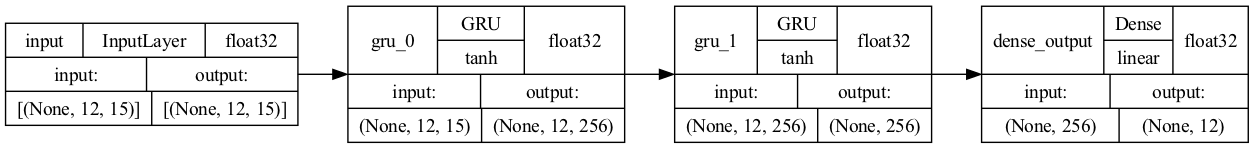

In [69]:
# Model 2 x GRU
tf.keras.utils.plot_model(model, dpi=100, rankdir='LR',
                          show_shapes=True, show_layer_names=True, show_dtype=True,
                          expand_nested=True, show_layer_activations=True)

# 5 Evaluation
## 5.1 Model training and result evaluation
Training a neural network is essential for making the network capable of performing a specific task, such as classification, regression, or image recognition. During training, the neural network learns from the input data and adjusts its internal parameters to minimize the discrepancy between its predictions and the actual target values.

Training is necessary for a neural network to learn patterns, relationships, and features from the data, enabling it to perform a specific task effectively, generalize to new data, adapt to different problems, optimize performance, automatically extract features, handle complex data, and be customized for specific applications. Without training, a neural network would not be able to make meaningful predictions or perform any useful tasks.



In [50]:
def backtesting(model: tf.keras.models.Model,
                ds: WindowGen,
                patience: int = 0):
    """Implementation of the backtesting for time series

    Parameters:
    __________
    model: tensorflow.keras.models.Model
        The compiled model to be trained in the backtesting.

    ds: WindowGen
        Dataset that will be used for training, validation and testing.

    patience: int
        Number of epochs with no improvement after which training will be stopped.

    Returns:
    ________
    ???
    """
    # ASSERTIONS
    if not isinstance(model, tf.keras.models.Model):
        raise TypeError(f'model must be keras Model, not {type(model)}')

    if not isinstance(ds, WindowGen):
        raise TypeError(f'ds must be WindowGen, not {type(ds)}')

    if not isinstance(patience, int):
        raise TypeError(f'patience must be int, not {type(patience)}')

    if patience < 0:
        raise ValueError('patience must be above or equal to zero')

    # Container to save the train history
    df = pd.DataFrame()
    df_best_results = pd.DataFrame()
    test_loss = []
    test_mae = []

    # Save the initial state of the model
    tf.keras.models.save_model(model, 'tmp_model.keras', overwrite=True)

    # Model callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_root_mean_squared_error',
        patience=patience,
        mode='min',
        restore_best_weights=True,
    )
    logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

    # Iterate all folds
    for fold_n in range(ds.total_folds):
        print(f'Fold number: {fold_n}')

        # Load the initial state of the model and change the fold number
        if fold_n:
            model = tf.keras.models.load_model('tmp_model.keras')
            ds.set_fold_number(fold_n)

        # Train the model
        history = model.fit(
            ds.train,
            validation_data=ds.val,
            epochs=100,
            callbacks=[early_stopping, tensorboard_callback],
            verbose=0,
        )

        # Save the fold history
        df_fold = pd.DataFrame(history.history)
        df_fold['fold_n'] = fold_n
        df_fold['epochs'] = range(len(df_fold))
        df = pd.concat([df, df_fold], ignore_index=True)


        # Evaluate the model on the test set
        test_result = model.evaluate(ds.test, verbose=0)
        test_loss.append(test_result[0])
        test_mae.append(test_result[1])

        # Print the fold statistics
        best_epoch = df_fold.loc[:, 'epochs'].max() - patience
        # print(best_epoch)
        best_row = df_fold.loc[df_fold.loc[:, 'epochs'] == best_epoch, :]
        # print(best_row)
        train_loss = best_row.loc[:, 'loss'].min()
        train_rmse = best_row.loc[:, 'root_mean_squared_error'].min()
        val_loss = best_row.loc[:, 'val_loss'].min()
        val_rmse = best_row.loc[:, 'val_root_mean_squared_error'].min()
        print(f'The best epoch: {best_epoch}')
        print(f'Train Loss: {train_loss:.2f}')
        print(f'Train RMSE: {train_rmse:.4f}')
        print(f'Val Loss: {val_loss:.4f}')
        print(f'Val RMSE: {val_rmse:.4f}')
        print(f'Test Loss: {test_result[0]:.4f}')
        print(f'Test RMSE: {test_result[1]:.4f}')
        print()

        # Save best fold results
        df_best_results = pd.concat([df_best_results, best_row], ignore_index=True)

    # Print the final results
    epochs_mean = df_best_results.loc[:, 'epochs'].mean()
    epochs_std = df_best_results.loc[:, 'epochs'].std()
    loss_mean = df_best_results.loc[:, 'loss'].mean()
    loss_std = df_best_results.loc[:, 'loss'].std()
    rmse_mean = df_best_results.loc[:, 'root_mean_squared_error'].mean()
    rmse_std = df_best_results.loc[:, 'root_mean_squared_error'].std()
    val_loss_mean = df_best_results.loc[:, 'val_loss'].mean()
    val_loss_std = df_best_results.loc[:, 'val_loss'].std()
    val_rmse_mean = df_best_results.loc[:, 'val_root_mean_squared_error'].mean()
    val_rmse_std = df_best_results.loc[:, 'val_root_mean_squared_error'].std()
    print(f'Final results:')
    print(f'Average best epochs: {epochs_mean:.4f} +- {epochs_std:.4f}')
    print(f'Average Train Loss: {loss_mean:.4f} +- {loss_std:.4f}')
    print(f'Average Train RMSE: {rmse_mean:.4f} +- {rmse_std:.4f}')
    print(f'Average Val Loss: {val_loss_mean:.4f} +- {val_loss_std:.4f}')
    print(f'Average Val RMSE: {val_rmse_mean:.4f} +- {val_rmse_std:.4f}')
    print(f'Average Test Loss: {np.mean(test_loss):.4f} +- {np.std(test_loss):.4f}')
    print(f'Average Test RMSE: {np.mean(test_mae):.4f} +- {np.std(test_mae):.4f}')
    final_result = (f'{epochs_mean:.4f} +- {epochs_std:.4f}\n'
                    f'{loss_mean:.4f} +- {loss_std:.4f}\n'
                    f'{rmse_mean:.4f} +- {rmse_std:.4f}\n'
                    f'{val_loss_mean:.4f} +- {val_loss_std:.4f}\n'
                    f'{val_rmse_mean:.4f} +- {val_rmse_std:.4f}\n'
                    f'{np.mean(test_loss):.4f} +- {np.std(test_loss):.4f}\n'
                    f'{np.mean(test_mae):.4f} +- {np.std(test_mae):.4f}\n')
    print(final_result)

    return df, final_result


In [51]:
ds = WindowGen(input_window=INPUT_MONTHS,
               output_window=OUTPUT_MONTHS,
               batch_size=16,
               df=df,
               label_columns=['CPI_shifted'],
               backtesting_type='refit_increase',
               total_folds=3,
               fold_number=0,
               train_ratio=0.55,
               val_ratio=0.35,
               )

ds

df_history, _ = backtesting(model, ds, patience=20)

Fold number: 0


2023-09-10 23:32:12.434565: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


The best epoch: 3
Train Loss: 0.19
Train RMSE: 0.3554
Val Loss: 0.1715
Val RMSE: 0.3289
Test Loss: 0.7528
Test RMSE: 0.8304

Fold number: 1
The best epoch: 9
Train Loss: 0.08
Train RMSE: 0.1599
Val Loss: 0.1495
Val RMSE: 0.3099
Test Loss: 0.4208
Test RMSE: 0.6061

Fold number: 2
The best epoch: 7
Train Loss: 0.09
Train RMSE: 0.1801
Val Loss: 1.8958
Val RMSE: 1.3572
Test Loss: 0.2883
Test RMSE: 0.4841

Final results:
Average best epochs: 6.3333 +- 3.0551
Average Train Loss: 0.1193 +- 0.0617
Average Train RMSE: 0.2318 +- 0.1075
Average Val Loss: 0.7389 +- 1.0019
Average Val RMSE: 0.6653 +- 0.5992
Average Test Loss: 0.4873 +- 0.1954
Average Test RMSE: 0.6402 +- 0.1434
6.3333 +- 3.0551
0.1193 +- 0.0617
0.2318 +- 0.1075
0.7389 +- 1.0019
0.6653 +- 0.5992
0.4873 +- 0.1954
0.6402 +- 0.1434


In [52]:
def history_charts(df: pd.DataFrame):
    """Draw the model training charts."""
    # ASSERTIONS
    if not isinstance(df, pd.DataFrame):
        raise TypeError(f'df must be a pandas DataFrame, not {type(df)}')

    must_columns = ['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error', 'fold_n', 'epochs']
    if any(col not in df.columns for col in must_columns):
        raise ValueError(f'df must contain the following columns: {must_columns}')

    # Collect all folds in DataFrame
    folds = set(df_history.loc[:, 'fold_n'])

    # Iterate all folds
    for fold_n in folds:
        # Filter the folder history
        df_fold = df.loc[df.loc[:, 'fold_n'] == 0, :]

        # Plot charts
        plt.style.use('seaborn-v0_8-whitegrid')
        plt.rcParams['figure.figsize'] = [20, 10]
        with plt.rc_context({'lines.linewidth': 4, 'lines.linestyle': '--'}):
            df_fold.plot(x='epochs', y=['loss', 'val_loss'], title=f'Fold #: {fold_n}', xlabel='Epochs', ylabel='Loss');
            df_fold.plot(x='epochs', y=['root_mean_squared_error', 'val_root_mean_squared_error'], xlabel='Epochs', ylabel='Mean Absolute Error');

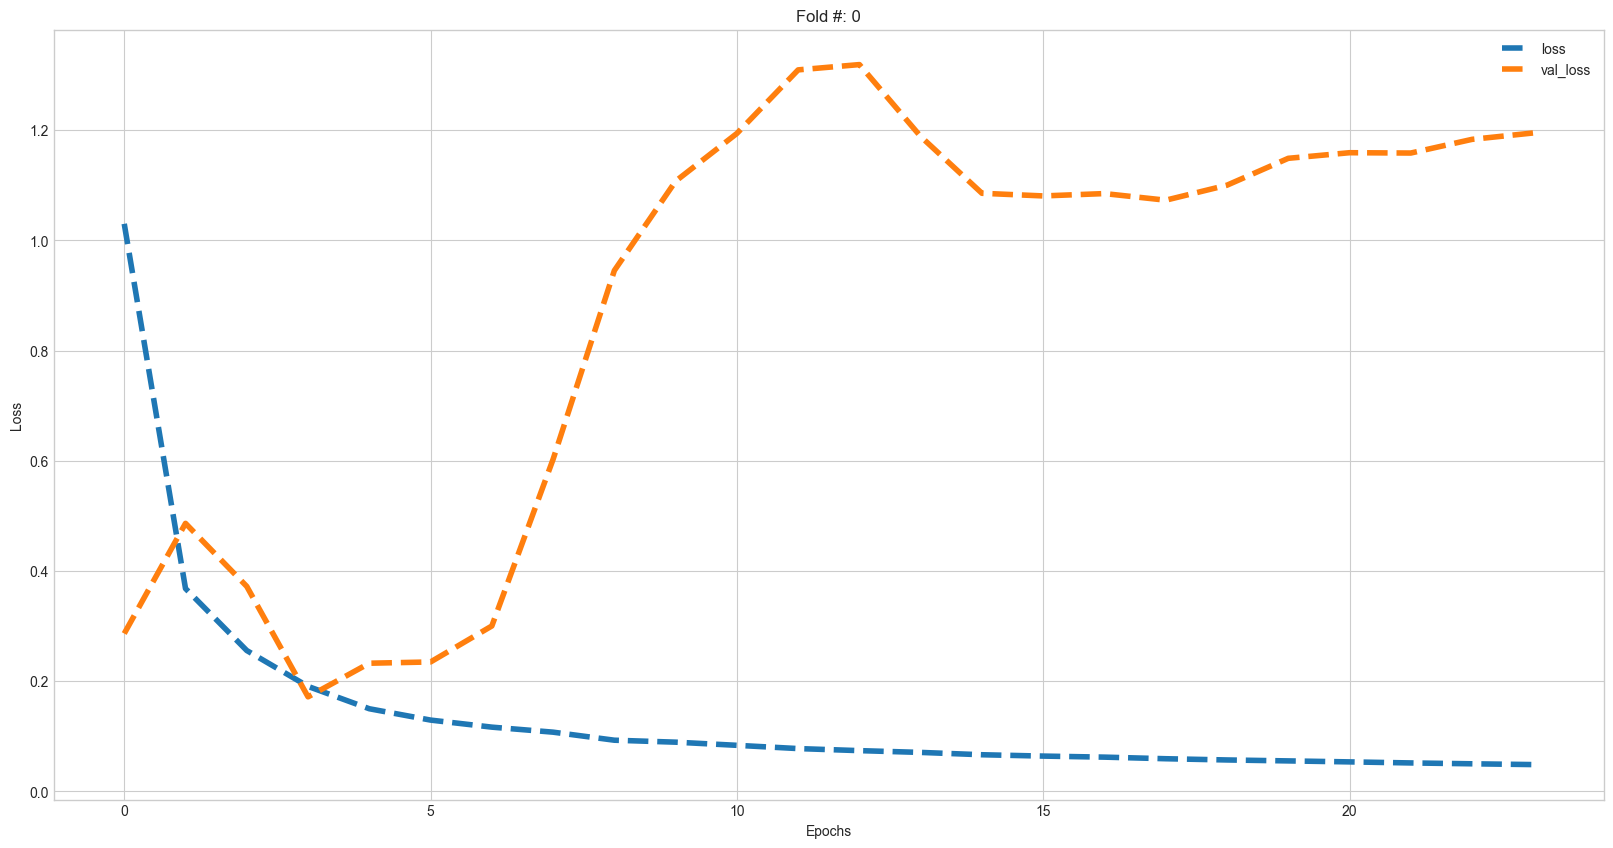

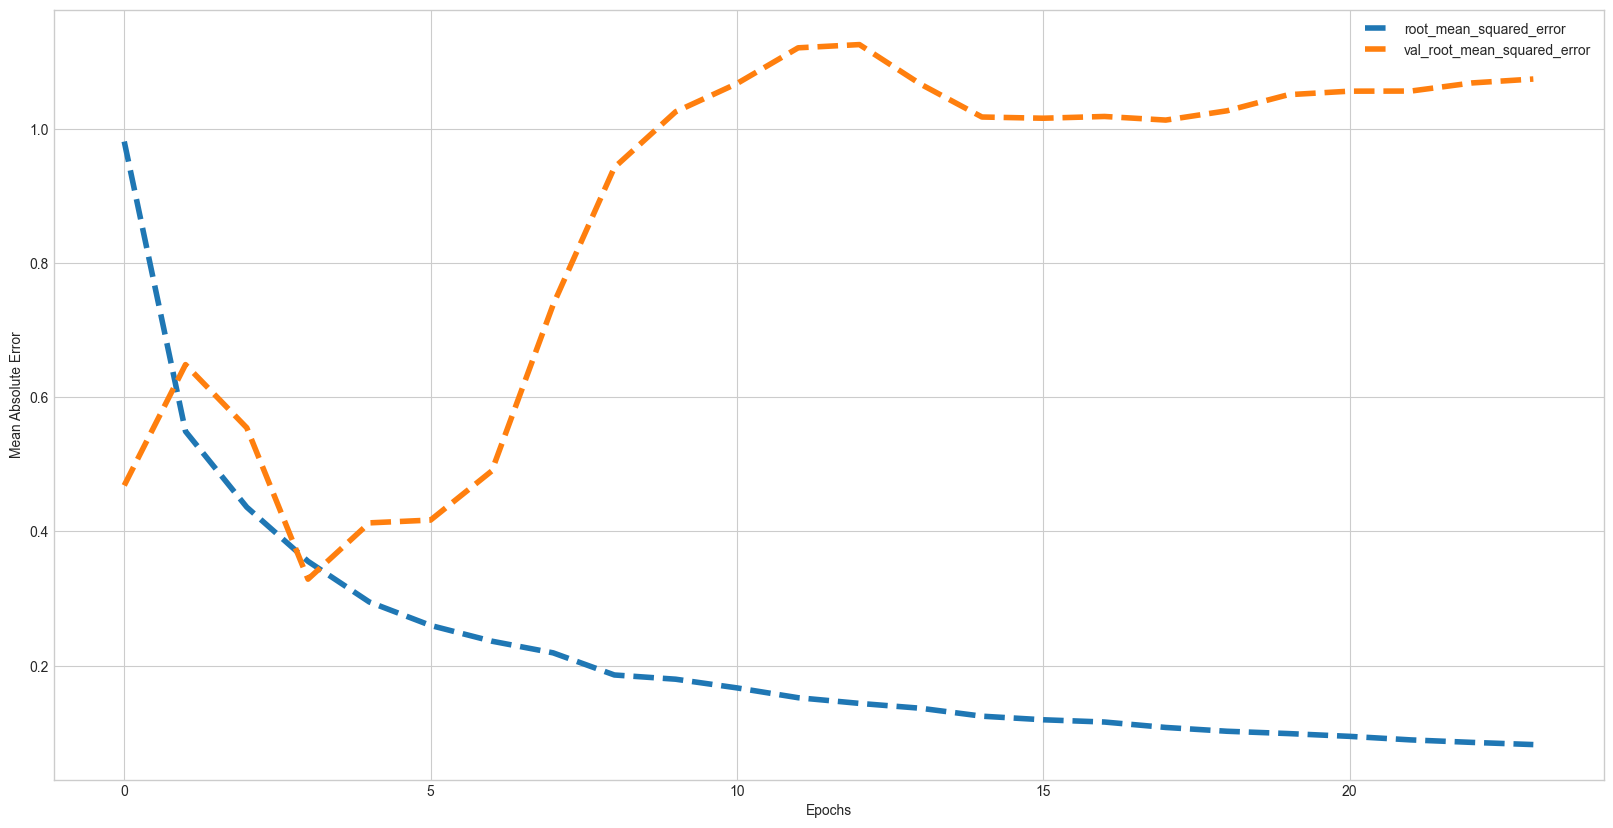

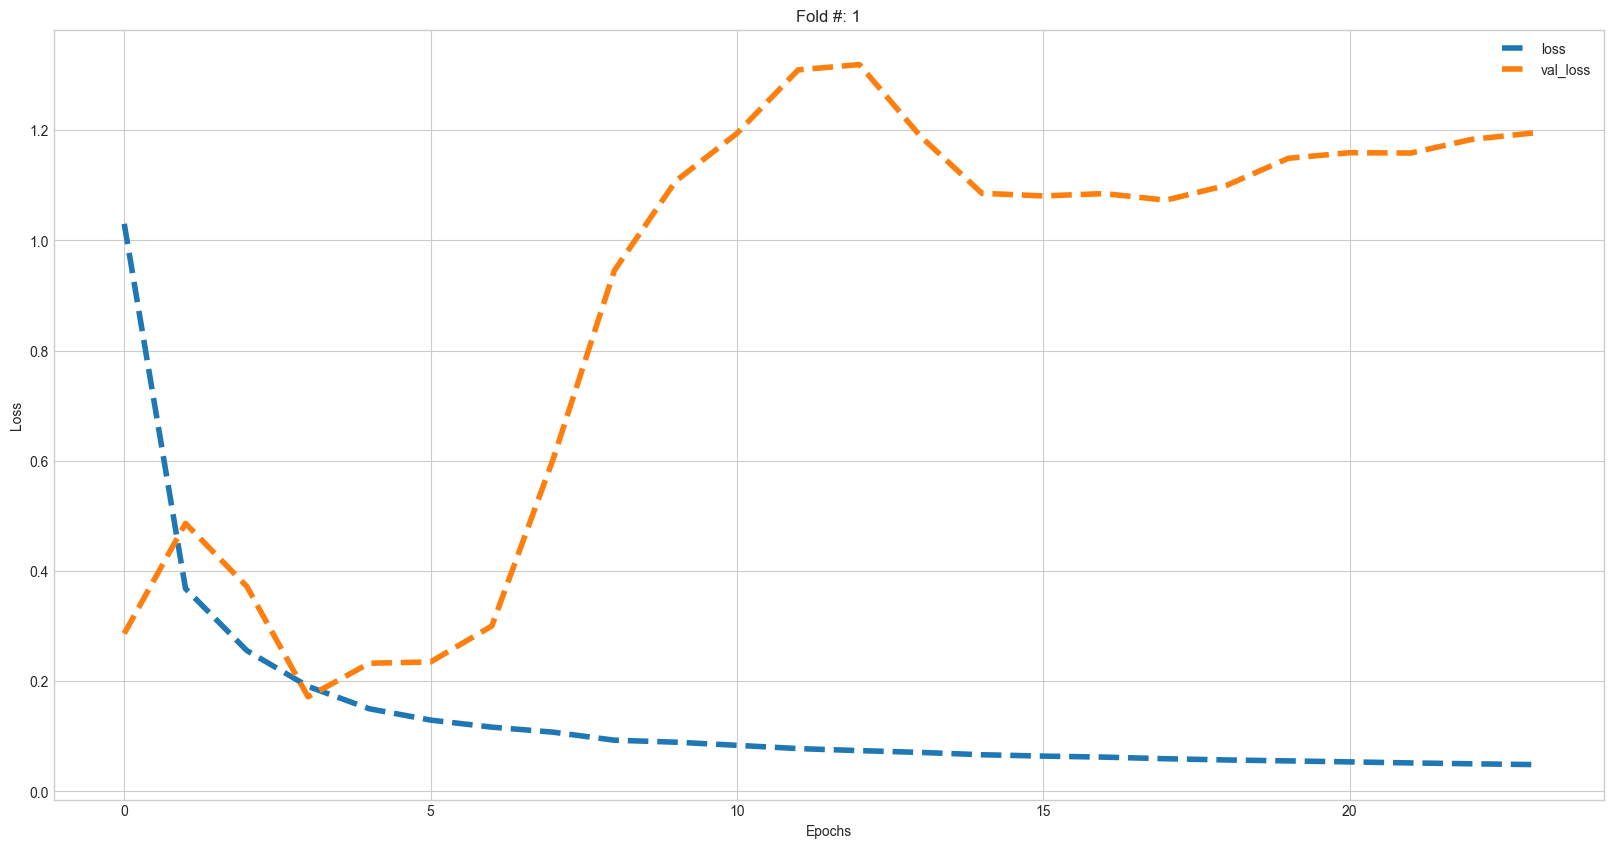

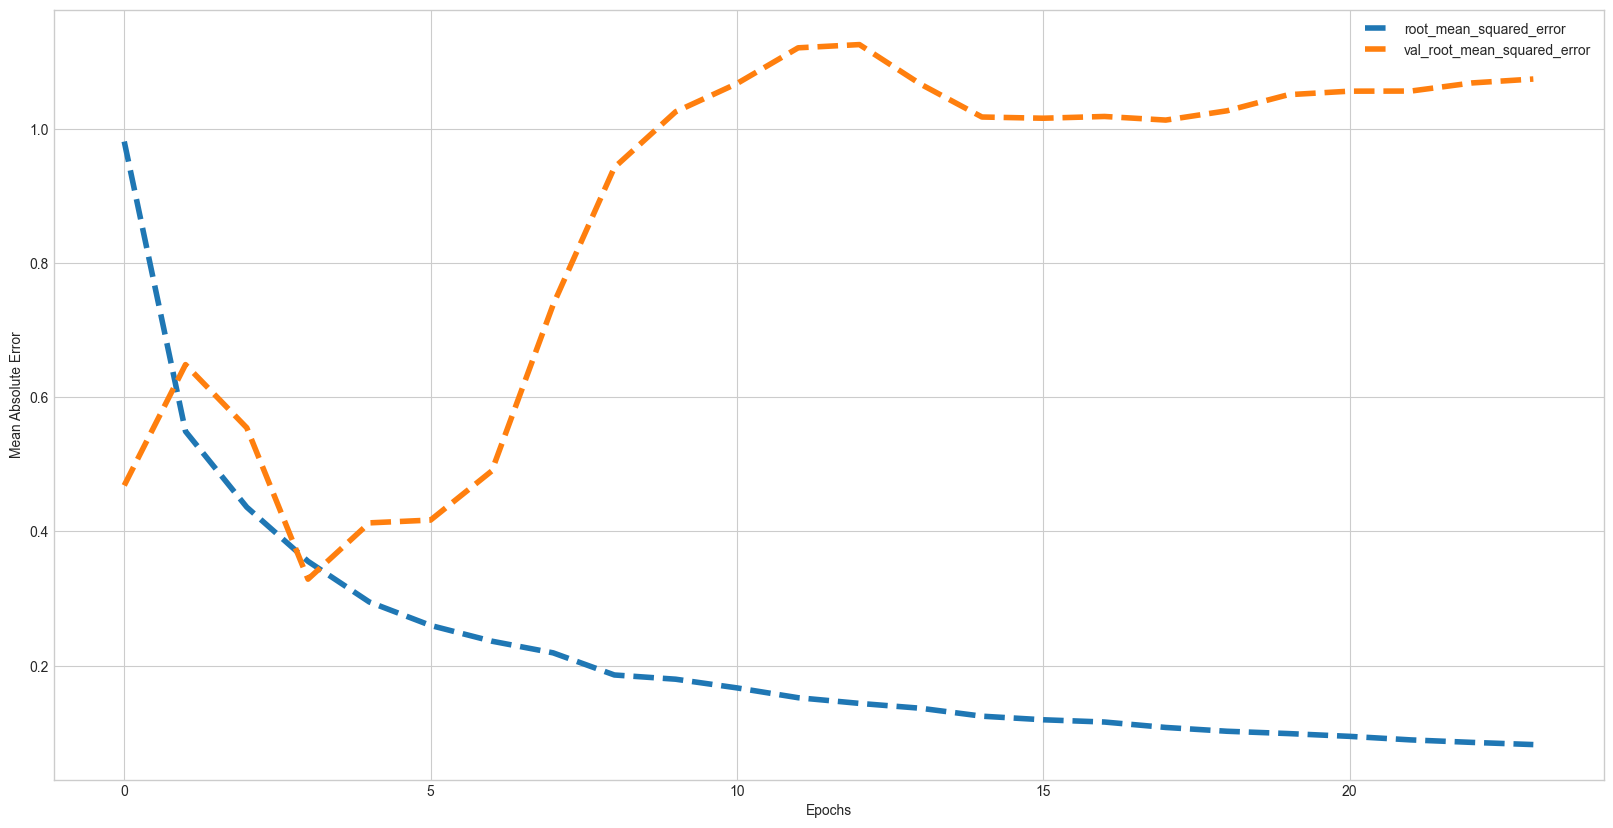

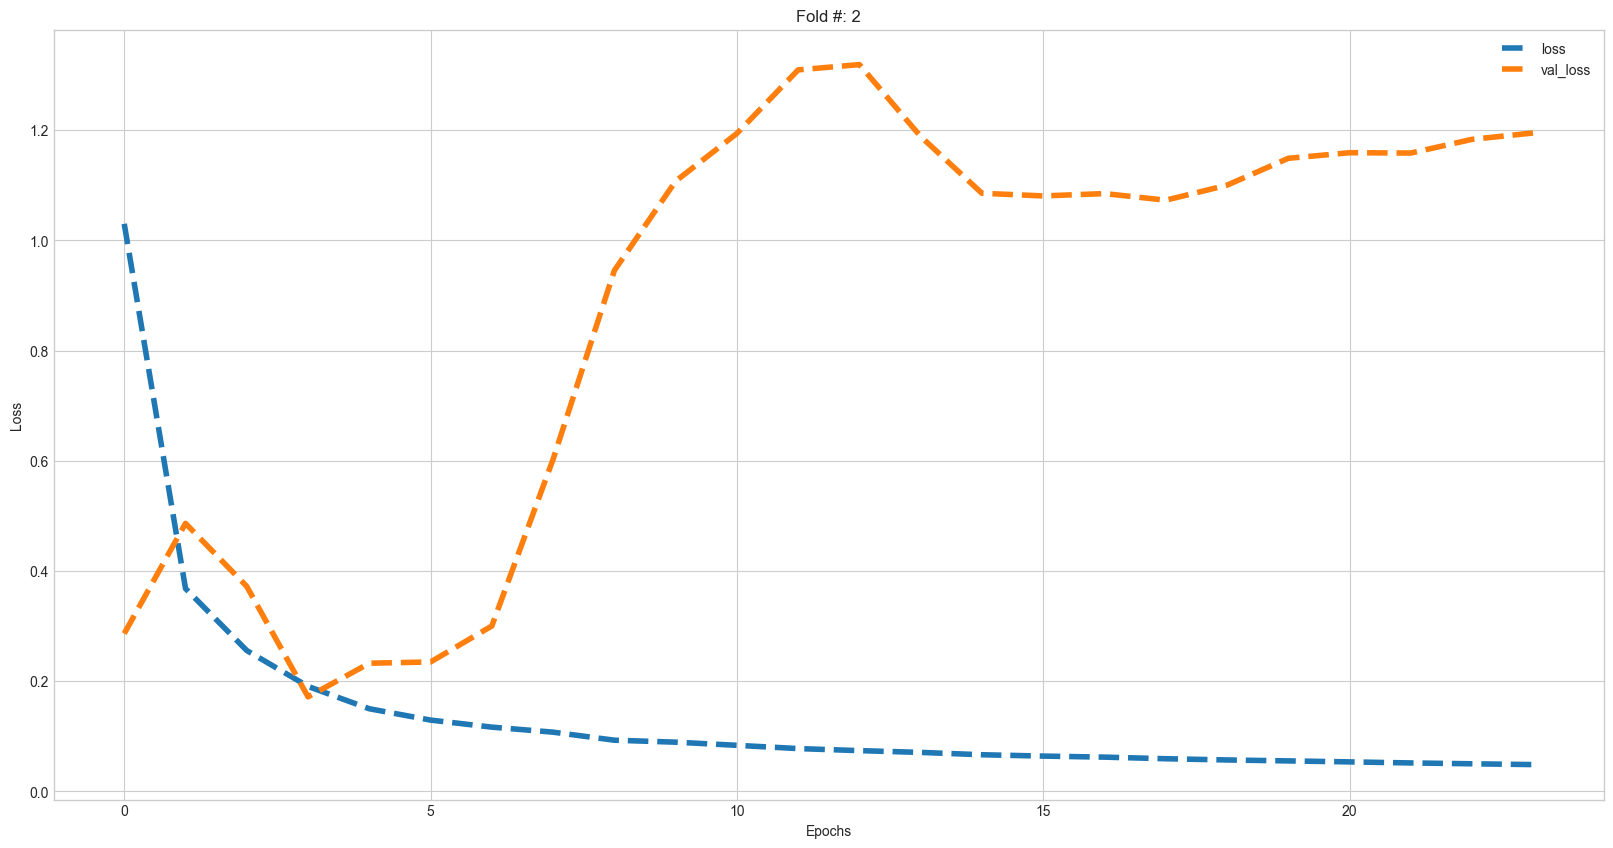

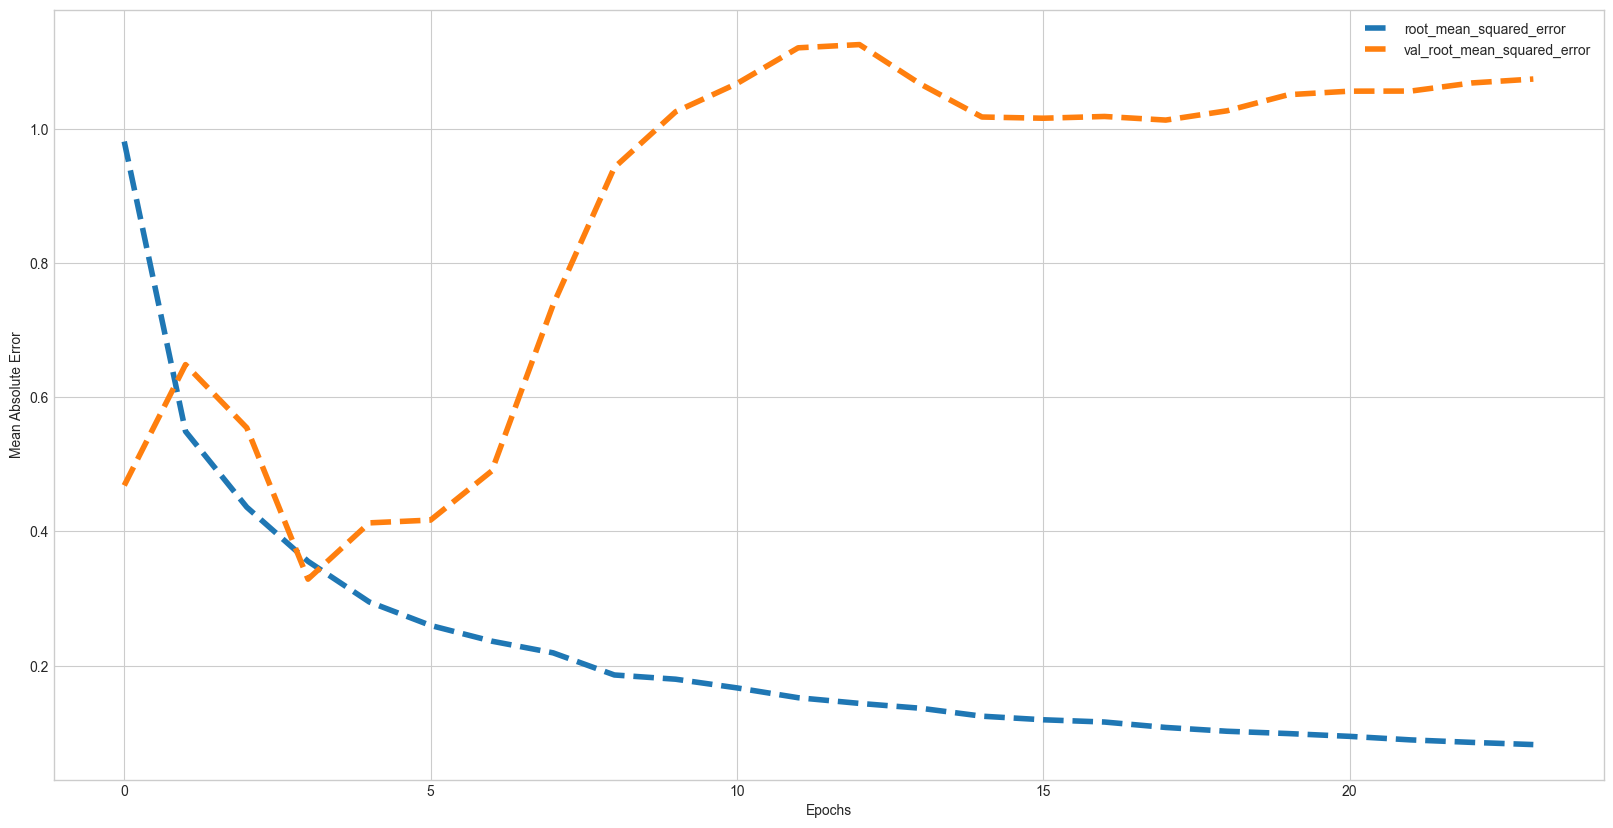

In [53]:
history_charts(df_history)

 ## 6.2 Model training on the entire dataset

In [62]:
ds = WindowGen(input_window=INPUT_MONTHS,
               output_window=OUTPUT_MONTHS,
               batch_size=16,
               df=df,
               label_columns=['CPI_shifted'],
               backtesting_type='refit_increase',
               total_folds=0,
               fold_number=0,
               train_ratio=0.8,
               val_ratio=0.0,
               )

ds

Input Window: 12
Output Window: 12
Total Folds: 0
Current fold number: 0
Batch size: 16
All items in DataFrame: 108
Train items: 86
Val All items: 0
Val Fold items: None
Test items: 22
Sample column indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Sample column name(s): ['Sin', 'CPI', 'Gov spending all', 'Corporate loans', 'Individual entrepreneur loans', 'Individual loans', 'CNYRUB', 'EURRUB', 'USDRUB', 'Key Ratio', 'RUONIA', 'RUONIA volume', 'Moscow InterBank Rate', 'Moscow InterBank Turnover', 'Wages']
Label column indices: [15]
Label column name(s): ['CPI_shifted']

In [63]:
# 2 x GRU
model = create_model(
    input_window=INPUT_MONTHS,
    n_features=N_FEATURES,
    output_window=OUTPUT_MONTHS,
    layer_types=['gru', 'gru'],
    layer_units=[256, 256],
    activations=['tanh', 'tanh'],
    recurrent_activations=['sigmoid', 'sigmoid'],
    kernel_regulizers=[keras.regularizers.L2(1e-3), keras.regularizers.L2(1e-4)],
    recurrent_regularizers=[None, None],
    bias_regularizers=[None, None],
    activity_regulizers=[None, None],
    dropouts=[0.0, 0.0],
    recurrent_dropouts=[0.0, 0.0],
    output_kernel_regularizer=None,
    output_bias_regularizer=None,
    output_activity_regularizer=None,
    optimizer=tf.keras.optimizers.legacy.Adam(),
)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 12, 15)]          0         
                                                                 
 gru_0 (GRU)                 (None, 12, 256)           209664    
                                                                 
 gru_1 (GRU)                 (None, 256)               394752    
                                                                 
 dense_output (Dense)        (None, 12)                3084      
                                                                 
Total params: 607,500
Trainable params: 607,500
Non-trainable params: 0
_________________________________________________________________


In [64]:
model.fit(ds.train, epochs=7)

Epoch 1/7
5/5 [==============================] - 2s 48ms/step - loss: 0.8789 - root_mean_squared_error: 0.9009
Epoch 2/7
5/5 [==============================] - 0s 26ms/step - loss: 0.2855 - root_mean_squared_error: 0.4689
Epoch 3/7
5/5 [==============================] - 0s 30ms/step - loss: 0.2018 - root_mean_squared_error: 0.3714
Epoch 4/7
5/5 [==============================] - 0s 24ms/step - loss: 0.1535 - root_mean_squared_error: 0.3019
Epoch 5/7
5/5 [==============================] - 0s 25ms/step - loss: 0.1391 - root_mean_squared_error: 0.2797
Epoch 6/7
5/5 [==============================] - 0s 22ms/step - loss: 0.0979 - root_mean_squared_error: 0.1968
Epoch 7/7
5/5 [==============================] - 0s 23ms/step - loss: 0.1058 - root_mean_squared_error: 0.2196


In [65]:
model.evaluate(ds.test)

1/1 [==============================] - 0s 401ms/step - loss: 1.7389 - root_mean_squared_error: 1.2970


[1.7388790845870972, 1.2970428466796875]

In [66]:
# Make predictions for the test dataset
y_pred = model.predict(ds.test)

# Denormolise predictions
y_pred = y_pred * ds.train_std.loc['CPI_shifted'] + ds.train_mean['CPI_shifted']

1/1 [==============================] - 0s 320ms/step


In [67]:
# Prepare pandas Series base on the test dataset
s_pred = ds.df.loc[ds.df_test_ind, 'CPI_shifted'].copy()

# Denormolise data
s_pred = s_pred * ds.train_std['CPI_shifted'] + ds.train_mean['CPI_shifted']

# Shift dates to compensate shifted labels
s_pred.index = s_pred.index.shift(periods=INPUT_MONTHS, freq='M')

# Rename the label column
s_pred.rename('CPI_true', inplace=True)

s_pred

2021-11-30     8.42
2021-12-31     8.39
2022-01-31     8.76
2022-02-28     9.16
2022-03-31    16.68
2022-04-30    17.84
2022-05-31    17.11
2022-06-30    15.89
2022-07-31    15.09
2022-08-31    14.30
2022-09-30    13.69
2022-10-31    12.63
2022-11-30    11.98
2022-12-31    11.94
2023-01-31    11.76
2023-02-28    10.97
2023-03-31     3.50
2023-04-30     2.31
2023-05-31     2.50
2023-06-30     3.25
2023-07-31     4.30
2023-08-31     5.12
Name: CPI_true, dtype: float64

In [68]:
df_pred = pd.DataFrame(s_pred)

# Iterate all predictions
for i in range(y_pred.shape[0]):

    # Add predictions to the Test DataFrame
    df_pred.loc[df_pred.index[i:i + OUTPUT_MONTHS], f'y_pred_{i}'] = y_pred[i]

df_pred

,CPI_true,y_pred_0,y_pred_1,y_pred_2,y_pred_3,y_pred_4,y_pred_5,y_pred_6,y_pred_7,y_pred_8,y_pred_9,y_pred_10
2021-11-30,8.42,8.073760,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-31,8.39,8.846298,8.644117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-31,8.76,7.964167,9.408779,8.966080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-28,9.16,7.757607,8.433822,9.905627,9.419836,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-31,16.68,7.441088,8.047723,8.460894,10.332252,10.257701,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-30,17.84,7.634065,7.612166,8.241014,9.026056,11.068140,12.643792,NaN,NaN,NaN,NaN,NaN
2022-05-31,17.11,7.100885,7.855073,7.736071,8.621552,9.831152,12.794030,14.374263,NaN,NaN,NaN,NaN
2022-06-30,15.89,5.845365,7.163559,7.788440,7.967044,9.143736,11.383503,14.341920,15.266048,NaN,NaN,NaN
2022-07-31,15.09,6.808514,5.730503,7.377918,8.113922,8.286901,10.058475,12.523610,15.463234,15.237030,NaN,NaN
2022-08-31,14.30,6.247247,6.748029,5.503293,7.545242,8.537176,8.746984,10.756473,13.469904,15.823771,14.779200,NaN


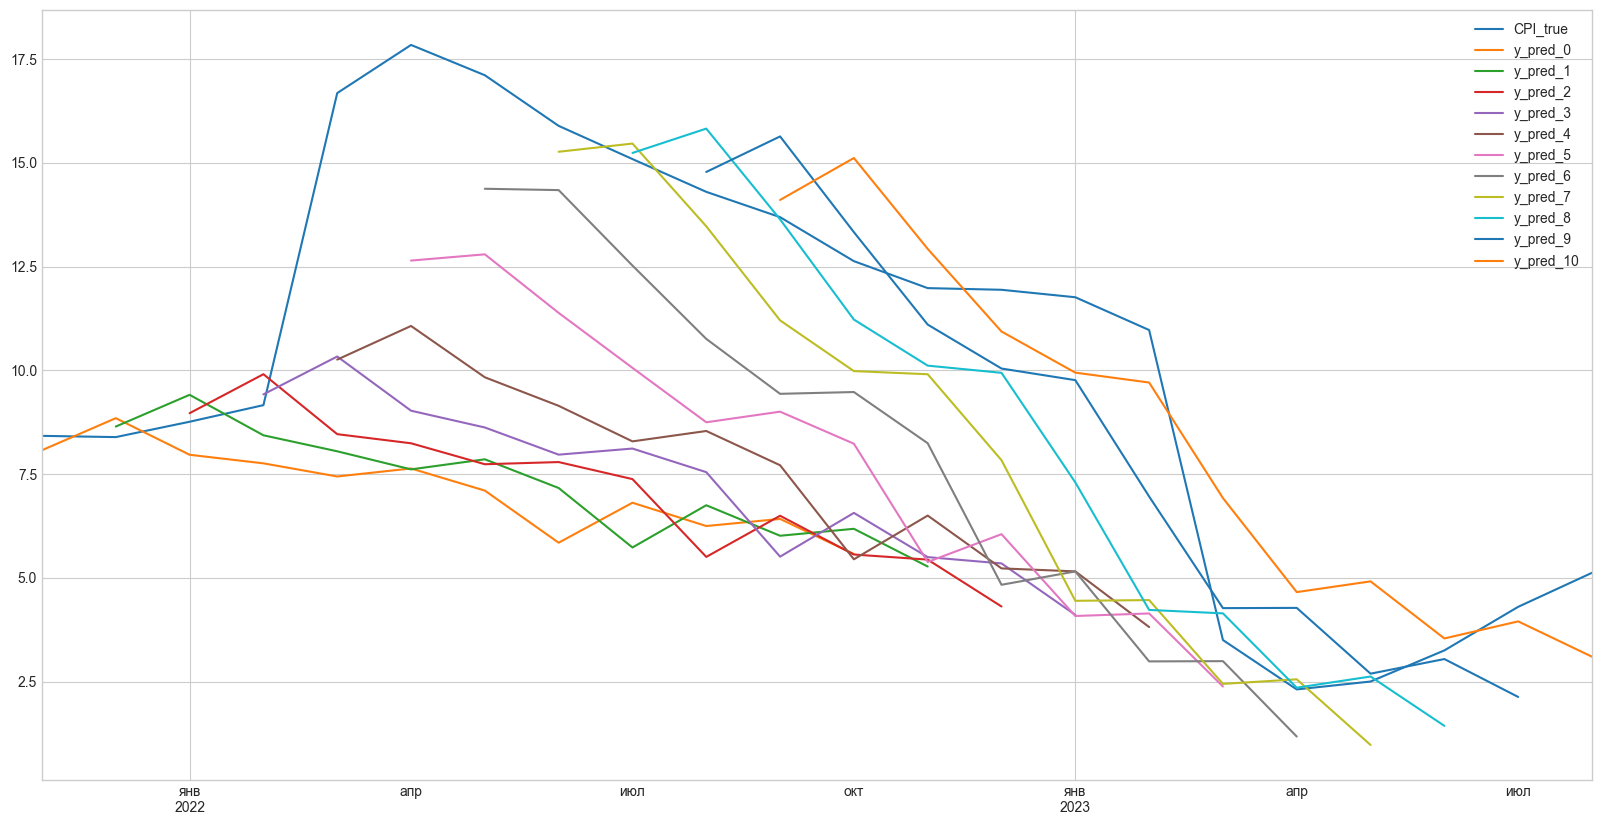

In [69]:
df_pred.plot(y=df_pred.columns);

# 6 CPI Forecast
In this section, I will be crafting a projection for the Consumer Price Index (CPI) covering the upcoming 12 months. This forecast will be built upon current and historical data, providing a comprehensive outlook on potential inflationary trends for the year ahead.

In [202]:
# df[:-2] because two last rows have nan values 
ds = WindowGen(input_window=INPUT_MONTHS,
               output_window=OUTPUT_MONTHS,
               batch_size=16,
               df=df,
               label_columns=['CPI_shifted'],
               backtesting_type='refit_increase',
               total_folds=0,
               fold_number=0,
               train_ratio=1.0,
               val_ratio=0.0,
               )

ds

Input Window: 12
Output Window: 12
Total Folds: 0
Current fold number: 0
Batch size: 16
All items in DataFrame: 108
Train items: 108
Val All items: 0
Val Fold items: None
Test items: 0
Sample column indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Sample column name(s): ['Sin', 'CPI', 'Gov spending all', 'Corporate loans', 'Individual entrepreneur loans', 'Individual loans', 'CNYRUB', 'EURRUB', 'USDRUB', 'Key Ratio', 'RUONIA', 'RUONIA volume', 'Moscow InterBank Rate', 'Moscow InterBank Turnover', 'Wages']
Label column indices: [15]
Label column name(s): ['CPI_shifted']

In [203]:
# 2 x GRU
model = create_model(
    input_window=INPUT_MONTHS,
    n_features=N_FEATURES,
    output_window=OUTPUT_MONTHS,
    layer_types=['gru', 'gru'],
    layer_units=[256, 256],
    activations=['tanh', 'tanh'],
    recurrent_activations=['sigmoid', 'sigmoid'],
    kernel_regulizers=[keras.regularizers.L2(1e-3), keras.regularizers.L2(1e-4)],
    recurrent_regularizers=[None, None],
    bias_regularizers=[None, None],
    activity_regulizers=[None, None],
    dropouts=[0.0, 0.0],
    recurrent_dropouts=[0.0, 0.0],
    output_kernel_regularizer=None,
    output_bias_regularizer=None,
    output_activity_regularizer=None,
    optimizer=tf.keras.optimizers.legacy.Adam(),
)

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 12, 15)]          0         
                                                                 
 gru_0 (GRU)                 (None, 12, 256)           209664    
                                                                 
 gru_1 (GRU)                 (None, 256)               394752    
                                                                 
 dense_output (Dense)        (None, 12)                3084      
                                                                 
Total params: 607,500
Trainable params: 607,500
Non-trainable params: 0
_________________________________________________________________


In [204]:
model.fit(ds.train, epochs=7)

Epoch 1/7
7/7 [==============================] - 2s 48ms/step - loss: 1.0673 - root_mean_squared_error: 1.0003
Epoch 2/7
7/7 [==============================] - 0s 29ms/step - loss: 0.4499 - root_mean_squared_error: 0.6207
Epoch 3/7
7/7 [==============================] - 0s 23ms/step - loss: 0.2914 - root_mean_squared_error: 0.4777
Epoch 4/7
7/7 [==============================] - 0s 24ms/step - loss: 0.2377 - root_mean_squared_error: 0.4193
Epoch 5/7
7/7 [==============================] - 0s 23ms/step - loss: 0.2289 - root_mean_squared_error: 0.4104
Epoch 6/7
7/7 [==============================] - 0s 24ms/step - loss: 0.1791 - root_mean_squared_error: 0.3462
Epoch 7/7
7/7 [==============================] - 0s 23ms/step - loss: 0.1721 - root_mean_squared_error: 0.3380


In [205]:
# Merge all tables by index. All rows with NaN are dropped
df = pd.concat([df_sin, df_cpi_cleaned, df_exp_budget, df_loans, df_exchange_rates, df_kr_ruonia_mkr, df_wages], axis=1, join='outer')

# Prepare the output range
datetime_now = datetime.now()
output_range = pd.date_range(end=datetime_now, periods=OUTPUT_MONTHS, freq='1M', normalize=True)

# In the output range we need only CPI (labels) data
# Therefore, I can drop all NA in the DataFrame except output range
# and leave only CPI data in the output range
df = pd.concat([df.loc[~df.index.isin(output_range)].dropna(),
                df.loc[df.index.isin(output_range) & ~df.loc[:, 'CPI'].isna()]],
               axis=0)

# Drop rows where we do not have targets
df.dropna(inplace=True)

df

,Sin,CPI,Gov spending all,Corporate loans,Individual entrepreneur loans,Individual loans,CNYRUB,EURRUB,USDRUB,Key Ratio,RUONIA,RUONIA volume,Moscow InterBank Rate,Moscow InterBank Turnover,Wages
2013-09-30,9.898214e-01,6.12,973.638538,22863.833705,640.716838,9270.501732,5.327400,43.483200,32.601670,5.5,6.180455,79.455909,6.253636,222021.985000,29346.0
2013-10-31,9.096320e-01,6.25,1129.859430,23167.709261,652.410868,9401.594342,5.257922,43.747678,32.099226,5.5,5.980870,70.309130,6.065652,213058.662174,30069.0
2013-11-30,5.406408e-01,6.49,1035.249401,23499.660266,659.189212,9613.944408,5.365754,44.152510,32.694000,5.5,6.106842,61.536316,6.187895,237616.248947,30290.0
2013-12-31,1.224647e-16,6.47,2226.233798,23930.204490,664.905809,9768.007462,5.411896,45.028610,32.880705,5.5,6.429524,70.251905,6.397273,260639.938636,39648.0
2014-01-31,-1.224647e-16,6.03,761.156476,23678.042484,672.408046,9957.094353,5.583935,46.058759,33.784353,5.5,6.047059,82.335882,6.056471,170644.068824,29535.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-28,-5.406408e-01,10.97,2536.816417,58456.722015,822.690185,27571.455522,10.659783,78.145283,72.782750,7.5,7.164444,466.174444,7.144850,400381.302000,65094.0
2023-03-31,-9.096320e-01,3.50,2221.550737,60086.174815,843.631055,27836.410257,11.016345,81.432809,76.103586,7.5,7.326667,367.077143,7.340824,340162.362667,71334.0
2023-04-30,-9.898214e-01,2.31,3069.819452,61204.330508,881.955345,28330.232254,11.739700,88.829481,80.995543,7.5,7.149500,341.805000,7.159200,312946.970440,71204.0
2023-05-31,-7.557496e-01,2.50,2013.745580,62652.209420,921.244161,28817.425169,11.302137,86.077647,79.212595,7.5,7.214286,408.043810,7.260648,399757.255086,72851.0


In [206]:
class WindowGenPred():
    """The generator of data windows for train, validation and test datasets.
    """
    def __init__(self, *,
                 input_window: int,
                 output_window: int,
                 batch_size: int = 1,
                 df: pd.DataFrame,
                 ):
        """A constructor to initialize a new WindowGen object.
        Parameters
        ----------
        input_window: int
            The number of elements from the dataset that will be used to create
            the running window of samples. 
            
        output_window: int
            The number of elements from the dataset that will be used to create
            the running window of labels.

        batch_size: int
            The size of the batch to train the model.

        df: pandas.DataFrame
            The pandas DataFrame that contains dataset.
        """

        # ASSERTIONS
        # Type Errors
        if not isinstance(input_window, int):
            raise TypeError(f'input_window must be an int, not '
                            f'{type(input_window)}')

        if not isinstance(batch_size, int):
            raise TypeError(f'batch_size must be an int, not '
                            f'{type(batch_size)}')

        if not isinstance(df, pd.DataFrame):
            raise TypeError(f'df must be a pandas DataFrame, not {type(df)}')

        # Value Errors
        if input_window < 0:
            raise ValueError('input_window must be above zero')

        if batch_size < 0:
            raise ValueError('batch_size must be above zero')


        # Save variables
        self.input_window = input_window
        self.output_window = output_window
        self.batch_size = batch_size
        self.df_orig = df.copy()
        self.df = df.copy()
        self.n_train = None
        self.n_pred = None

        # Prepare train and prediction dataset indices 
        self.df_train_ind = None
        self.df_pred_ind = None
        self.__prepare_indices()

        # Data normalisation
        self.train_mean = None
        self.train_std = None
        self.__data_normalisation()

        # Compute sample columns, number of features, number of labels
        self.sample_columns = df.columns
        self.n_features = len(self.sample_columns)

        # Compute the sample and label column indices.
        self.sample_column_indices = [i for i, col in enumerate(df.columns) if col in self.sample_columns]

    def __prepare_indices(self):
        """Prepare train and prediction dataset indices."""

        # Prepare train indices
        self.df_train_ind = self.df.iloc[:-self.output_window].index
        self.n_train = self.df_train_ind.shape[0]

        # Prepare prediction indices
        self.df_pred_ind = self.df.iloc[-self.output_window:].index
        self.n_pred = self.df_pred_ind.shape[0]

    def __data_normalisation(self):
        """Normalise data in DataFrames based on the train dataset."""

        # # Restore denormalised data
        self.df = self.df_orig.copy()
        # 
        # # Prepare mean and standard deviation values based on the train dataset
        # self.train_mean = self.df.loc[self.df_train_ind].mean()
        # self.train_std = self.df.loc[self.df_train_ind].std()
        self.train_mean = ds.train_mean.copy()
        self.train_mean.drop('CPI_shifted', inplace=True)
        self.train_std = ds.train_std.copy()
        self.train_std.drop('CPI_shifted', inplace=True)
        
        # Normalise dataset
        self.df = (self.df - self.train_mean) / self.train_std

    def __repr__(self):
        return '\n'.join([
            f'Input Window: {self.input_window}',
            f'Output Window: {self.output_window}',
            f'Batch size: {self.batch_size}',
            f'All items in DataFrame: {len(self.df)}',
            f'Train items: {self.n_train}',
            f'Prediction All items: {self.n_pred}',
            f'Sample column indices: {self.sample_column_indices}',
            f'Sample column name(s): {self.sample_columns}',
        ])

    def make_dataset(self, indices: pd.DatetimeIndex) -> tf.data.Dataset:
        """Transform pandas DataFrame to TensorFlow dataset.

        The dataset will be split into the (dataset length - input window + 1) containers.

        Example:
        Dataset Items = 7 | Input window width = 5 | Output window width = 3 | Number of windows = 7 - 5 + 1 = 3
        Input window 0: 0 - 4 | Output window 0: 0 - 2
        Input window 1: 1 - 5 | Output window 0: 1 - 3
        Input window 2: 2 - 6 | Output window 0: 2 - 4

        Parameters
        ----------
        indices: pandas.DatetimeIndex
            The DataFrame indices to filter out the DataFrame.

        Returns:
        __________
        TensorFlow dataset on Success, or None.
        """

        # Slice Pandas Dataframe by indices
        df = self.df.loc[indices]

        # Calculate the number of windows
        if (number_of_windows := len(df) - self.input_window + 1) >= 1:
            pass
            # number_of_windows = len(df) - self.input_window + 1
        # Not enough data to fill the window
        else:
            raise AssertionError('Not enough data to fill the window')

        # Create containers for samples and labels
        X = np.zeros((number_of_windows, self.input_window, self.n_features), dtype=np.float64)
        y = np.zeros((number_of_windows, self.output_window, 1), dtype=np.float64)

        # Iterate all window containers and fill them by data from pandas DataFrame
        for i in range(number_of_windows):
            X_window = df.iloc[i:i + self.input_window, self.sample_column_indices].to_numpy(dtype=np.float64)

            # Check that DataFrame has enough data to fill the input window
            # if not enough, add additional rows filled by zeros
            if len(X_window) < self.input_window:
                zero_values = np.zeros((self.input_window - len(X_window), self.n_features))
                X_window = np.vstack([X_window, zero_values])

            # Fill the window array by data from DataFrame
            X[i] = X_window
            # y[i] = np.zeros((self.output_window, self.n_features))

        # Transform numpy ndarray to Tensorflow dataset
        ds_x = tf.data.Dataset.from_tensor_slices(X)
        ds_y = tf.data.Dataset.from_tensor_slices(y)

        # Zip sample and labels datasets
        ds = tf.data.Dataset.zip((ds_x, ds_y))

        # Divide dataset into batches by batch size
        return ds.batch(self.batch_size)

    @property
    def train(self) -> tf.data.Dataset:
        """Prepare the train Tensorflow dataset divided by windows."""
        return self.make_dataset(self.df_train_ind)

    @property
    def pred(self) -> tf.data.Dataset:
        """Prepare the test Tensorflow dataset divided by windows."""
        return self.make_dataset(self.df_pred_ind)

In [208]:
ds_pred = WindowGenPred(
    input_window=INPUT_MONTHS,
    output_window=OUTPUT_MONTHS,
    batch_size=1,
    df=df,
)

ds_pred

Input Window: 12
Output Window: 12
Batch size: 1
All items in DataFrame: 118
Train items: 106
Prediction All items: 12
Sample column indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Sample column name(s): Index(['Sin', 'CPI', 'Gov spending all', 'Corporate loans',
       'Individual entrepreneur loans', 'Individual loans', 'CNYRUB', 'EURRUB',
       'USDRUB', 'Key Ratio', 'RUONIA', 'RUONIA volume',
       'Moscow InterBank Rate', 'Moscow InterBank Turnover', 'Wages'],
      dtype='object')

In [209]:
ds_pred.df_orig.loc[ds_pred.df_pred_ind]

,Sin,CPI,Gov spending all,Corporate loans,Individual entrepreneur loans,Individual loans,CNYRUB,EURRUB,USDRUB,Key Ratio,RUONIA,RUONIA volume,Moscow InterBank Rate,Moscow InterBank Turnover,Wages
2022-07-31,2.817326e-01,15.09,2682.120186,49688.585543,733.105398,25572.932343,8.793905,59.169236,58.221400,9.071429,8.865238,162.466667,8.856500,149303.035667,62200.0
2022-08-31,7.557496e-01,14.30,2097.784840,51893.580983,744.409559,25824.601346,8.890038,61.041973,60.391918,8.000000,7.940435,186.600000,7.932883,195842.130726,59907.0
2022-09-30,9.898214e-01,13.69,2221.883889,53036.879978,757.299869,26103.428727,8.524762,59.263600,59.821500,7.761905,7.679524,184.497619,7.666467,198945.555529,61879.0
2022-10-31,9.096320e-01,12.63,2248.198994,53932.767019,775.290450,26513.634765,8.464925,59.845100,61.115843,7.500000,7.711818,221.011364,7.667600,231827.508118,62470.0
2022-11-30,5.406408e-01,11.98,2252.279794,55774.179556,778.567513,26775.109771,8.445434,61.930238,60.852995,7.500000,7.315238,385.880476,7.296171,347686.479171,63060.0
2022-12-31,1.224647e-16,11.94,7081.963584,56314.528424,797.491969,27092.649792,9.378248,69.629852,65.814987,7.500000,7.324000,501.884000,7.317076,428121.666662,88468.0
2023-01-31,-1.224647e-16,11.76,3006.330687,58676.771509,822.328852,27437.807010,10.158781,74.499806,68.875975,7.500000,7.003889,463.240000,7.002056,402489.868483,63260.0
2023-02-28,-5.406408e-01,10.97,2536.816417,58456.722015,822.690185,27571.455522,10.659783,78.145283,72.782750,7.500000,7.164444,466.174444,7.144850,400381.302000,65094.0
2023-03-31,-9.096320e-01,3.50,2221.550737,60086.174815,843.631055,27836.410257,11.016345,81.432809,76.103586,7.500000,7.326667,367.077143,7.340824,340162.362667,71334.0
2023-04-30,-9.898214e-01,2.31,3069.819452,61204.330508,881.955345,28330.232254,11.739700,88.829481,80.995543,7.500000,7.149500,341.805000,7.159200,312946.970440,71204.0


In [210]:
# Make predictions for the test dataset
y_pred = model.predict(ds_pred.pred)

# Denormolise predictions
y_pred = y_pred * ds.train_std.loc['CPI_shifted'] + ds.train_mean['CPI_shifted']

1/1 [==============================] - 0s 363ms/step


In [212]:
range_ = pd.date_range(start=ds_pred.df_orig.index.max(), periods=OUTPUT_MONTHS + 1, freq='M')[1:]
df_pred = pd.DataFrame({'y_pred':y_pred[0]}, index=range_)

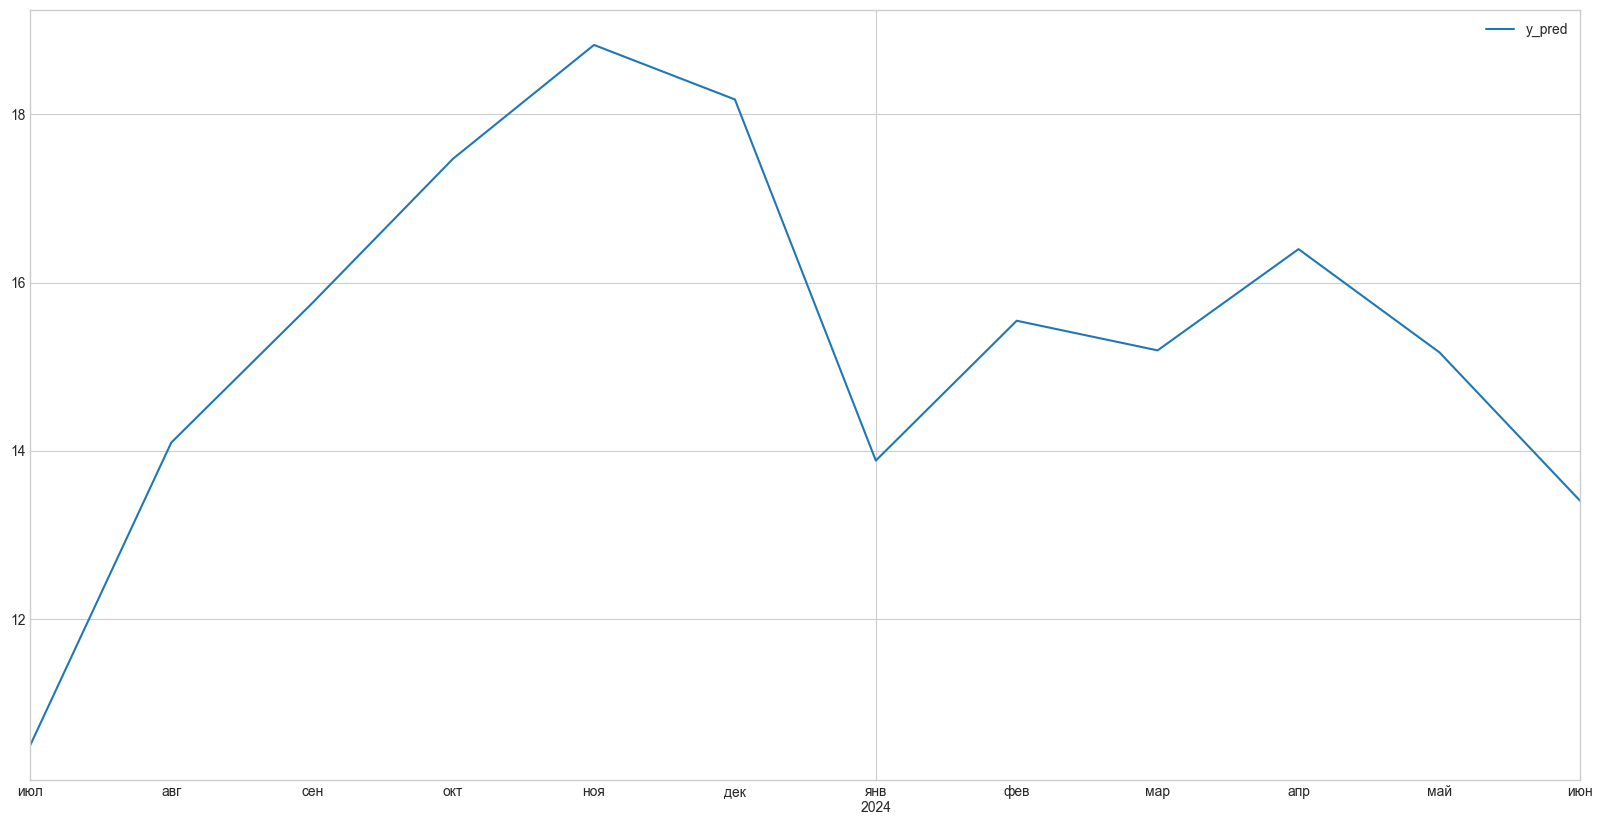

In [213]:
df_pred.plot();

# References
1. The Consumer Price Index (CPI) source, Rosstat Russia, website. https://rosstat.gov.ru/statistics/price
2. Goverment spending, Ministry of Finance Russia, website. https://minfin.gov.ru/ru/statistics/fedbud/execute?id_57=80042-informatsiya_ob_ispolnenii_federalnogo_byudzheta
3. Loans, Central Bank of Russia, website. https://www.cbr.ru/statistics/bank_sector/review/
4. tf.data: Build TensorFlow input pipelines. Website: https://www.tensorflow.org/guide/data?hl=en#time_series_windowing
5. Model Evaluation in Time Series Forecasting. Website: https://towardsdatascience.com/model-evaluation-in-time-series-forecasting-ae41993e267c
6. Tensorflow tf.data Pipeline for Multiple Time Series. Website:
https://medium.com/@kavyamalla/extending-tensorflows-window-generator-for-multiple-time-series-8b15eba57858
